In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tellurium as te 
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('../Estimation/')
from estimation import set_model_to_ss

In [3]:
fit_data_pth = pd.read_csv('../Estimation/pth.csv')
fit_data_non_pth = pd.read_csv('../Estimation/non_pth.csv')

## Figure Idea 1
- Establish that infection has oscilating behavior, if no medication given
- Establish that erythropoesis works by resuce if 10% reduction of erythrocytes
- medication kills infection

In [4]:
def simulate_model(model_path: str = '../LCT_model/general_LCT_OIE.ant', 
                   infection_pars: dict = {}, name: str='general',
                   ss_duration:float=4.,pre_t:float=10.0, simulation_end:float=100.0, 
                   bool_med= True, bool_set_pars=False,
                   selections:list=['time', '[R]', '[iE]', '[E]','[M]','[P]', 'oiE', 'Hkt',
                                     'Hb', 'LDH', 'parasitemia', 'RPI', 'J_oiE_death',
                                     'J_P_birth', 'J_P_death',
                                     'k_E_death','rpi_step_func'] + [f'[oiE_{i}]' for i in range(1, 7)]):
    """Simulates model for given BH_max value and returns dataframe with results. 
    Includes presimulation for specific time (infection_after)."""
    model = te.loada(model_path)
   
    if bool_set_pars:
        for p in infection_pars:
            model.setValue(p, infection_pars[p])
    # ss simulation
    model = set_model_to_ss(model, infection_pars, model_name=name)
    
    model.M = 0
    model.events_medication_on = False 
    ss_res = model.simulate(-ss_duration-pre_t, -pre_t, 10, selections=selections)
    ss_res_df = pd.DataFrame(ss_res, columns=ss_res.colnames)    

    # infection simulation
    if 'M' in infection_pars.keys():
        model.M = infection_pars['M']
    else: 
        model.M = 1e3

    for p in infection_pars:
        model.setValue(p, infection_pars[p])

    # ACT addition
    model.events_medication_on = bool_med
    act_res = model.simulate(-pre_t, simulation_end, 501, selections=selections) #int(simulation_end+pre_t)*10
    act_res_df = pd.DataFrame(act_res, columns=act_res.colnames) 

    # combine results
    res_df = pd.concat([ss_res_df, act_res_df], axis=0)    
    return res_df 

def pretty_plot(results, axs=None, c=None, bool_med=True):
    species_to_analyze = OrderedDict({
        'parasitemia' : ['parasitemia (%)', 1],
        #'[M]' : ['M (1e4/µl)', 1e4],
        '[iE]': ['iE (1e4/µl)', 1e4],
        'oiE': ['oiE (1e4/µl)', 1e4],
        '[E]': ['E (1e4/µl)', 1e4],
        '[R]': ['R (1e4/µl)', 1e4],
        #'[P]': ['P (1e0/µl)', 1e0],
        #'J_P_birth':['J_P_birth',1e0],
        'Hb': ['Hb (g/dl)', 1],
        'Hkt': ['Hct', 1],
        'RPI': ['RPI', 1],
        'LDH': ['LDH (U/l)',1],
    })
    if axs.dtype==None:
        # Durchführung des Parameter-Scans und Erstellung der Plots
        cols = 3
        rows = int(np.ceil(len(species_to_analyze)/cols))   

        fig, axs = plt.subplots(rows,cols, figsize=(10,7.5), sharex=True)
        fig.subplots_adjust(hspace=0.38, wspace= 0.42)
    size_of_font = 24

    # Farbübergang
    if c ==None:
        cmap = plt.colormaps.get_cmap('Reds')
        c=cmap(0.8)

    for j, specie in enumerate (species_to_analyze.keys()):

        row = j //3
        col = j % 3


        axs[row, col].plot(results['time'], results[specie]/species_to_analyze[specie][1],
                            color=c)
        #axs[row, col].set_xlabel('time (days)',fontsize= size_of_font)
        axs[row, col].set_ylabel(species_to_analyze[specie][0],fontsize= size_of_font)
        axs[row, col].tick_params(labelsize=size_of_font)
        if bool_med:
            axs[row, col].axvspan(0, 0.3, facecolor='mediumseagreen', alpha=1) #, label='ACT Administration')
            axs[row, col].axvspan(1, 1.3, facecolor='mediumseagreen', alpha=1,)
            axs[row, col].axvspan(2, 2.3, facecolor='mediumseagreen', alpha=1,)

        axs[row, col].axvline(-10, color='navy', alpha=1, linewidth=2, linestyle=(0, (3, 5, 1, 5)))
        axs[row, col].tick_params(bottom='on')   
        if row == 3 - 1:
                axs[row, col].set_xlabel('time (days)',fontsize= size_of_font)
        
    handles, labels = axs[row, col].get_legend_handles_labels()  # Legend Box outsides Subplots


    axs[-1, -1].legend(handles, labels, loc='lower left', 
                        bbox_to_anchor=(1.05, 0.7),fontsize= size_of_font) #bbox (nach rechts-links, oben-unten, negativ yes)

    #plt.savefig("./figures/paramscan_BHmax_short.pdf", format="pdf",bbox_inches='tight')
    #plt.show()
    return axs
def convert_bounds_to_logscale(bounds):
    """
    converts bounds for parameters from linear scale to log10 scale. If a bound is 0, it's replaced with 1e-8 to avoid infinity values in log scale.
    Input and output: Ordered dictionaries
    """
    log_bounds = OrderedDict({})

    for param, bound in bounds.items():
        if bound[0] == 0:
            bound = (bound[1]*1e-3, bound[1])
        log_bounds[param] = (np.log10(bound[0]), np.log10(bound[1]))

    return log_bounds

### Plot model with and without bystander haemolysis

In [5]:
k_iE_pit_frac = 0.5
pre_t_new = 10
k_E_infect = 1.452041851367283e-06
trop = 14
# simulate no by-stander haemolysis
#infect_pars = {'k_E_infect': k_infect, 's_BH': 0, 'k_iE_pit_frac': k_iE_pit_frac}
update_parameters_old = {
        "E": 5567010.309277952,
        "R": 46391.75257763841,
        "P": 271.8266752573979,
        "k_P_birth": 92.59782219413799,
        "LDH_RBC": 5.318123784272337e-10,
        "k_E_infect": k_E_infect,
        "tropism": trop,
        'k_M_death': 48,
        's_BH': 0,                              # only change here 
        "a_P_d": 59999.97948625444,
        "k_P_d": 0.0010000000517527397,
        "r_P_d": 5.870264855546418,
        "LDH": 197.37366622040253
}
update_parameters = {
        "E": 5517152.3419487635,
        "R": 86278.1264409893,
        "P": 619.8166906155667,
        "k_P_birth": 528.9286816372999,
        "LDH_RBC": 5.308386484771372e-10,
        "k_E_infect": 3.0050100663064395e-06,
        "tropism": 6.329243159661564,
        "M": 100.0000001442934,
        "a_P_d": 7374.146280948379,
        "k_P_d": 9.99596376311406,
        "r_P_d": 2.3576028642068314,
        "fac_R_d": 7.795701934289822e-11,
        "k_P_art_max": 5.129684025900893,
        "t_mat_P": 13.99999985601867,
        "slope_rpi": 1.0000000064593544,
        "k_iE_pit_frac": 0.6203739371362769,
        "t_E_death": 107.13356623796001,
        "s_BH": 9.999999986955698e-09,
        "LDH": 218.69655201339418,
        "k_M_death": 99.12061927650802
    }
infect_pars = update_parameters
no_bh_res = simulate_model(infection_pars=infect_pars,pre_t=pre_t_new, bool_set_pars=True)

# simulate by-stander haemolysis
#infect_pars = {'k_E_infect': k_infect, 's_BH': 1.361151210723645e-06,'k_iE_pit_frac': k_iE_pit_frac}#{'k_E_infect': k_infect, 's_BH': 1e-6 }
update_parameters_old = {
        "E": 5567010.309277952,
        "R": 46391.75257763841,
        "P": 271.8266752573979,
        "k_P_birth": 92.59782219413799,
        "LDH_RBC": 5.318123784272337e-10,
        "k_E_infect": k_E_infect,
        "tropism": trop,
        'k_M_death': 48,
        's_BH': 1.361151210723645e-06,          # only change here 
        "a_P_d": 59999.97948625444,
        "k_P_d": 0.0010000000517527397,
        "r_P_d": 5.870264855546418,
        "LDH": 197.37366622040253
}
update_parameters= {
        "E": 5509616.76894186,
        "R": 92306.58484651212,
        "P": 663.1247606045504,
        "k_P_birth": 565.7778131682766,
        "LDH_RBC": 5.503191875970027e-10,
        "k_E_infect": 3.0050100663064395e-06,
        "tropism": 6.329243159661564,
        "M": 100.0000001442934,
        "a_P_d": 7374.146280948379,
        "k_P_d": 9.99596376311406,
        "r_P_d": 2.3576028642068314,
        "fac_R_d": 7.795701934289822e-11,
        "k_P_art_max": 5.129684025900893,
        "t_mat_P": 13.99999985601867,
        "slope_rpi": 1.0000000064593544,
        "k_iE_pit_frac": 0.6203739371362769,
        "t_E_death": 100.00000000174617,
        "s_BH": 5.655783807209168e-07,
        "LDH": 242.56382593615703,
        "k_M_death": 97.84697656012995
    }
infect_pars = update_parameters
bh_res = simulate_model(infection_pars=infect_pars, pre_t=pre_t_new, bool_set_pars=True) 

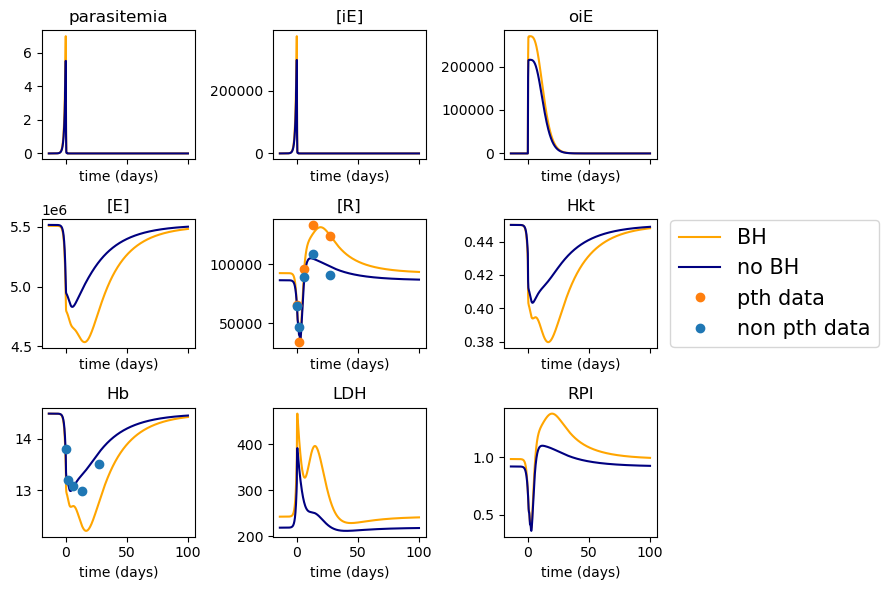

In [6]:
## plot results
observables = ['parasitemia', '[iE]', 'oiE',
               #'J_oiE_death', 'k_E_death',
               '[E]', '[R]', 'Hkt' ,'Hb', 'LDH','RPI',
               #'[M]','J_P_birth', 'J_P_death'
               ]
# 'rpi_step_func'
n_cols = 3
n_rows = int(np.ceil(len(observables)/n_cols))  
color= ['navy', 'orange']

fig, ax = plt.subplots(n_rows, n_cols, squeeze=True, sharex=True, figsize=(n_cols*3, n_rows*2))

for i, obs in enumerate(observables):
    row = i//n_cols
    col = i%n_cols
    ax[row, col].plot(bh_res['time'], bh_res[obs], color=color[1],label='BH')
    ax[row, col].plot(no_bh_res['time'], no_bh_res[obs],color=color[0], label='no BH')
    
    ax[row, col].set_title(obs)
    ax[row, col].set_xlabel('time (days)')
    #ax[row, col].legend()
ax[1,1].plot(fit_data_pth['Time'], fit_data_pth['[R]_mean'], 'o', label='pth data', color='tab:orange')
ax[1,1].plot(fit_data_non_pth['Time'], fit_data_non_pth['[R]_mean'], 'o', label='non pth data', color='tab:blue')
ax[2,0].plot(fit_data_non_pth['Time'], fit_data_non_pth['Hb_mean'], 'o', label='non pth data', color='tab:blue')
#ax[2,0].plot(fit_data_non_pth['Time'], fit_data_non_pth['Hb_mean'], 'o', label='pth data', color='tab:orange')

handles, labels = ax[1, 1].get_legend_handles_labels()  # Legend Box outsides Subplots

ax[1, -1].legend(handles, labels, loc='center left', 
                  bbox_to_anchor=(1.02, 0.5), fontsize=15
                  ) #bbox (nach rechts-links, oben-unten, negativ yes)
plt.tight_layout()  
plt.show()

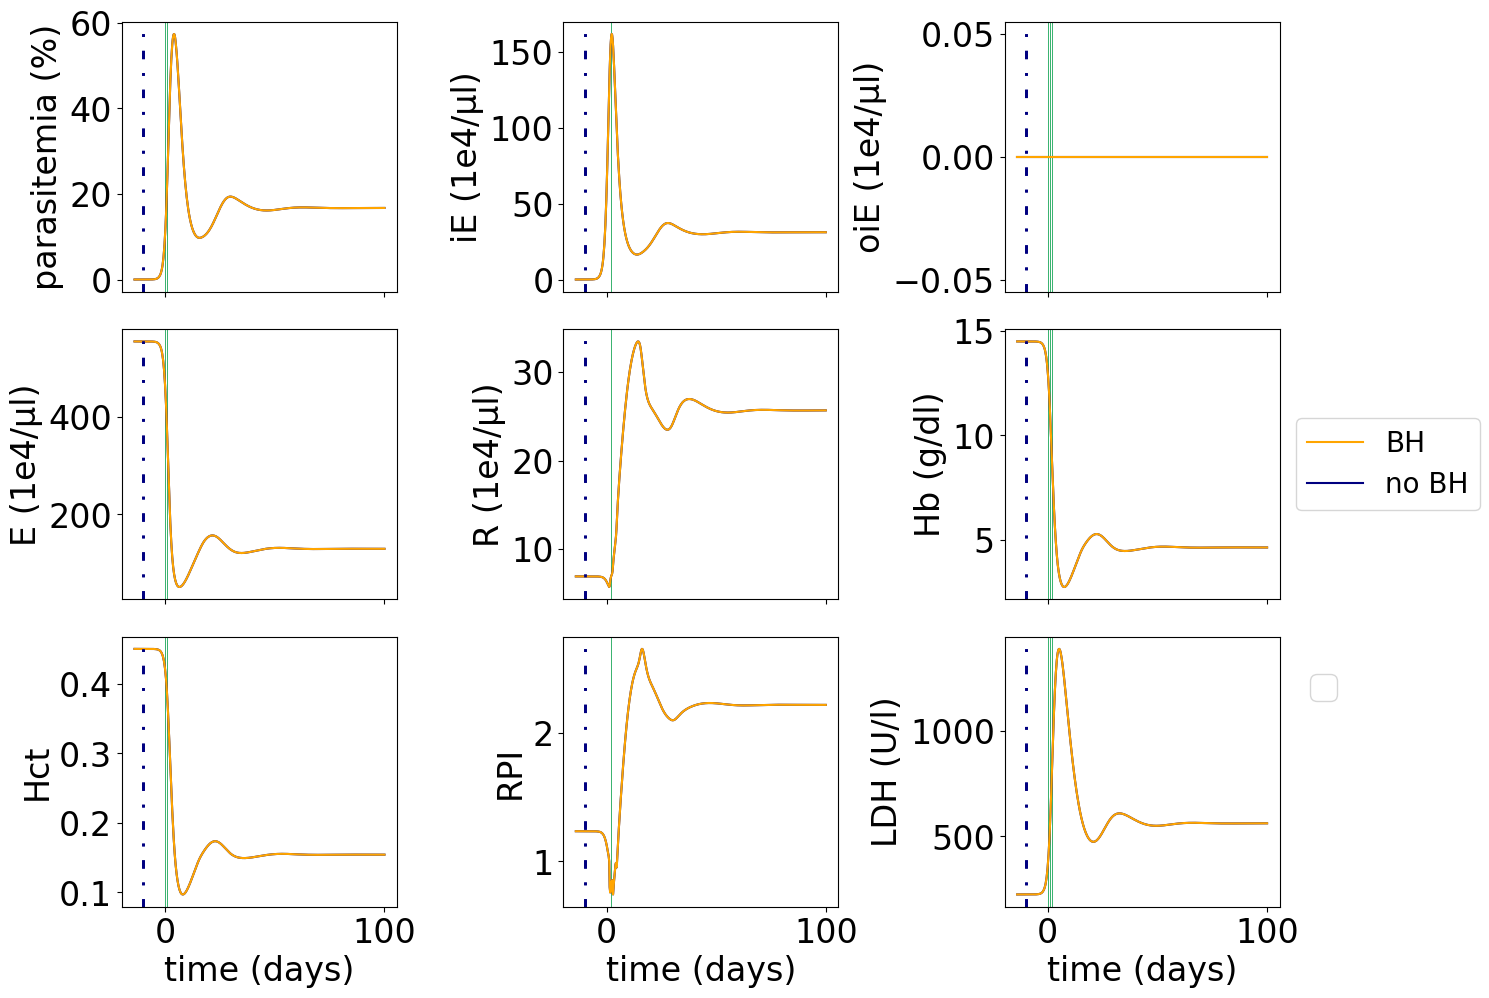

In [7]:
# simulate no by-stander haemolysis
update_parameters= {
        "E": 5538461.538703015,
        "R": 69230.76903758777,
        "P": 347.37273487562373,
        "k_P_birth": 232.81994101243959,
        "LDH_RBC": 4.0847546731267703e-10,
        "k_E_infect": 1.0351927708026337e-06,
        "tropism": 2.4824267001740767,
        "M": 100.0000740303447,
        "a_P_d": 9937191.134916836,
        "k_P_d": 0.009451056983160715,
        "r_P_d": 7.4265726002365495,
        "fac_R_d": 7.068386037799187e-10,
        "k_P_art_max": 2.709891804855283,
        "t_mat_P": 6.138028732895664,
        "k_iE_pit_frac": 0.6625125905514542,
        "t_E_death": 80.00000022727542,
        "s_BH": 7.105938524287848e-07, #change
        "LDH": 226.23256587878646,
        "k_M_death": 30.010891278063838
}
infect_pars = update_parameters
pre_t = 10.0

#no_meds = simulate_model(infection_pars=infect_pars, bool_med=True, simulation_end= 40)

cols = 3
rows = 3  
fig, axs_all = plt.subplots(rows,cols, figsize=(15,10), sharex=True)
fig.subplots_adjust(hspace=0.38, wspace= 0.42)
size_of_font = 24
#pretty_plot(no_meds, axs_all)
color= ['navy', 'orange']

for i,k in enumerate([0, 7.105938524287848e-07]):
        update_parameters['s_BH']=k
        no_meds = simulate_model(infection_pars=infect_pars,simulation_end= 100, bool_med=False)
        pretty_plot(no_meds, axs_all, c=color[i])
handles, labels = ax[1, 1].get_legend_handles_labels()  # Legend Box outsides Subplots
axs_all[1, -1].legend(handles,['BH','no BH'], loc='center left', 
                  bbox_to_anchor=(1.01, 0.5), fontsize=20
                  ) #bbox (nach rechts-links, oben-unten, negativ yes)
fig.tight_layout()
fig.show()

### Plot for damped oscilation of model
- [x] find parameter values for oscilation
    - parameter values are not the ones as used in model before
    - tropism = 1, if  > 2 it damps the oscilation to near none
        - parameter scan of interest
    - higher k_M_death = 96 or could lower k_E_infect to make oscilation possible

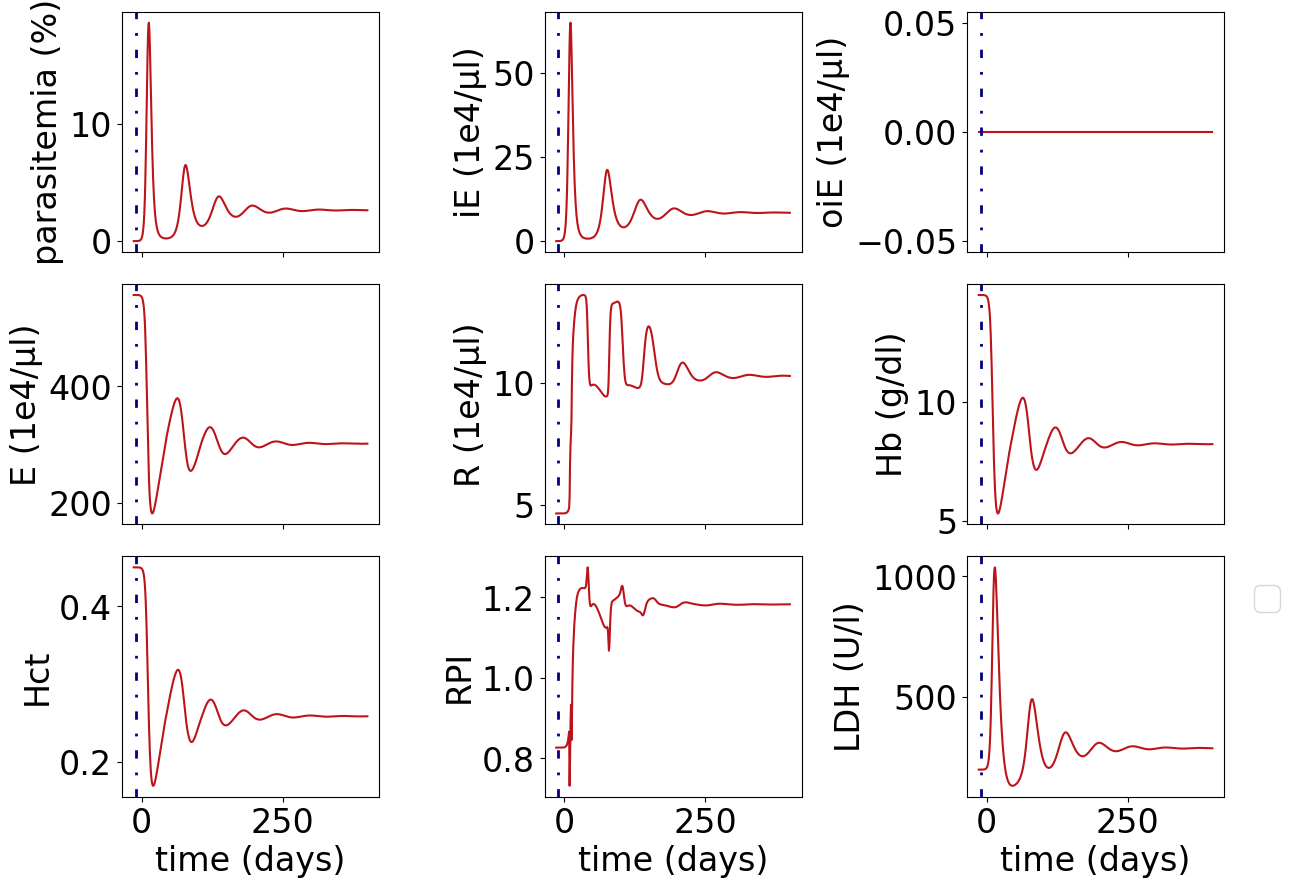

In [8]:

#PTH
update_pth= {
        "E": 5538461.538703015,
        "R": 69230.76903758777,
        "P": 347.37273487562373,
        "k_P_birth": 232.81994101243959,
        "LDH_RBC": 4.0847546731267703e-10,
        "k_E_infect": 1.0351927708026337e-06,
        "tropism": 2.4824267001740767,
        "M": 100.0000740303447,
        "a_P_d": 9937191.134916836,
        "k_P_d": 0.009451056983160715,
        "r_P_d": 7.4265726002365495,
        "fac_R_d": 7.068386037799187e-10,
        "k_P_art_max": 2.709891804855283,
        "t_mat_P": 6.138028732895664,
        "k_iE_pit_frac": 0.6625125905514542,
        "t_E_death": 80.00000022727542,
        "s_BH": 7.105938524287848e-07, #change
        "LDH": 226.23256587878646,
        "k_M_death": 30.010891278063838
}
# best for osci
osci_parameters2= {
        "E": 5567010.309277952,
        "R": 46391.75257763841,
        "P": 271.8266752573979,
        "k_P_birth": 92.59782219413799,
        "LDH_RBC": 5.318123784272337e-10,
        "k_E_infect": 2.052041851367283e-06,
        "tropism": 1,#4.429542038768788,
        'k_M_death': 96,
        "a_P_d": 59999.97948625444,
        "k_P_d": 0.0010000000517527397,
        "r_P_d": 5.870264855546418,
        "s_BH": 9.999999922941987e-09,
        "LDH": 197.37366622040253
}
#non-PTH
update_non_pth = {
        "E": 5538461.538479782,
        "R": 69230.76921617458,
        "P": 347.372735771702,
        "k_P_birth": 232.81994161015564,
        "LDH_RBC": 3.990636921288249e-10,
        "k_E_infect": 1.0351927708026337e-06,
        "tropism": 2.4824267001740767,
        "M": 100.0000740303447,
        "a_P_d": 9937191.134916836,
        "k_P_d": 0.009451056983160715,
        "r_P_d": 7.4265726002365495,
        "fac_R_d": 0,
        "k_P_art_max": 2.709891804855283,
        "t_mat_P": 6.138028732895664,
        "k_iE_pit_frac": 0.6625125905514542,
        "t_E_death": 80.00000001768396,
        "s_BH": 9.999999990164551e-09,
        "LDH": 221.01989097706704,
        "k_M_death": 35.742483391216822
    }

# simulate no by-stander haemolysis

infect_pars = osci_parameters2
pre_t = 10.0

no_meds = simulate_model(infection_pars=infect_pars, bool_set_pars=True, bool_med=False, simulation_end= 400)

cols = 3
rows = 3  
fig, axs_all = plt.subplots(rows,cols, figsize=(13,9),sharex=True)
fig.subplots_adjust(hspace=0.20, wspace= 0.50)
size_of_font = 12
pretty_plot(no_meds, axs_all, bool_med=False)
'''for k in range(4.1,4.2,1):
        update_parameters['tropism']=k
        no_meds = simulate_model(infection_pars=infect_pars, bool_med=False, simulation_end= 400)
        pretty_plot(no_meds, axs_all)'''
fig.tight_layout()
fig.show()

### Plot Erythropoiesis
Reduce Erythrocytes by 10% and hope they recover

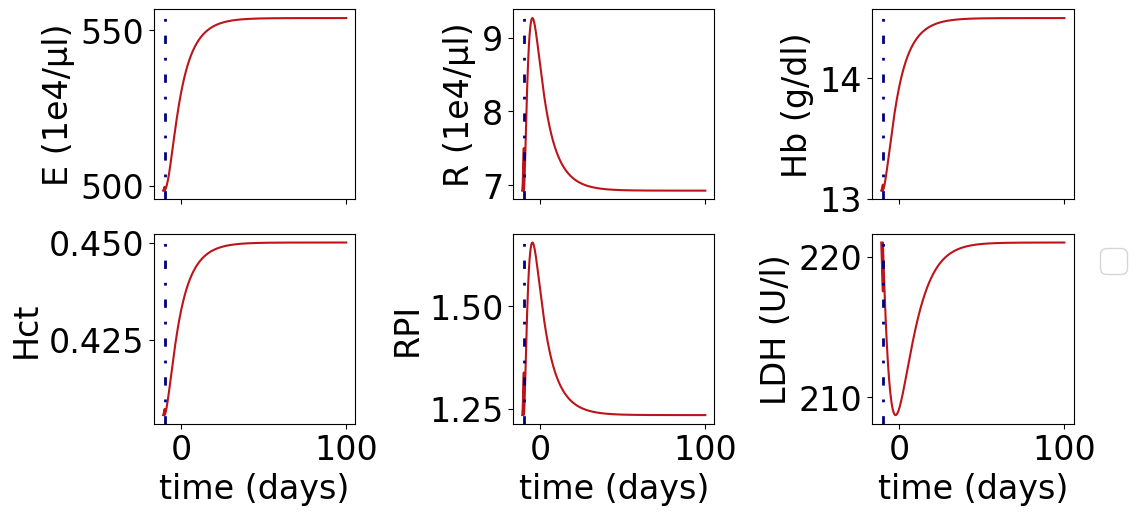

In [9]:
reduction = 0.9
# simulate no by-stander haemolysis
update_parameters= {
        "E": 5567010.309277952 * reduction,
        "R": 46391.75257763841,
        "P": 271.8266752573979,
        "k_P_birth": 92.59782219413799,
        "LDH_RBC": 5.318123784272337e-10,
        "k_E_infect": 0,
        "tropism": 1,#4.429542038768788,
        'k_M_death': 96,
        "a_P_d": 59999.97948625444,
        "k_P_d": 0.0010000000517527397,
        "r_P_d": 5.870264855546418,
        "s_BH": 9.999999922941987e-09,
        "LDH": 197.37366622040253
}
update_non_pth = {
        "E": 5538461.538479782 * reduction,
        "R": 69230.76921617458,
        "P": 347.372735771702,
        "k_P_birth": 232.81994161015564,
        "LDH_RBC": 3.990636921288249e-10,
        "k_E_infect": 0,
        "tropism": 2.4824267001740767,
        "M": 100.0000740303447,
        "a_P_d": 9937191.134916836,
        "k_P_d": 0.009451056983160715,
        "r_P_d": 7.4265726002365495,
        "fac_R_d": 0,
        "k_P_art_max": 2.709891804855283,
        "t_mat_P": 6.138028732895664,
        "k_iE_pit_frac": 0.6625125905514542,
        "t_E_death": 80.00000001768396,
        "s_BH": 9.999999990164551e-09,
        "LDH": 221.01989097706704,
        "k_M_death": 35.742483391216822
    }
infect_pars = update_non_pth
pre_t = 10.0

no_meds = simulate_model(infection_pars=infect_pars, bool_med=False,simulation_end= 100, ss_duration=1)

cols = 3
rows = 3  
fig, axs_all = plt.subplots(rows,cols, figsize=(11.5,7.5),sharex=True)
#fig.subplots_adjust(hspace=0.38, wspace= 0.42)
pretty_plot(no_meds, axs_all, bool_med=False)
'''for k in range(4.1,4.2,1):
        update_parameters['tropism']=k
        no_meds = simulate_model(infection_pars=infect_pars, bool_med=False, simulation_end= 400)
        pretty_plot(no_meds, axs_all)'''
axs_all.flat[0].set_visible(False)
axs_all.flat[1].set_visible(False)
axs_all.flat[2].set_visible(False)

fig.tight_layout()
fig.show()

## Fig2: Analysis of rpi Slope 

In [10]:
def plot_logistic(ax, e_slop, c):
    def logistic_function(x, slope, midpoint, scale):
        """Takes slope max and midpoint.  """
        val = scale / (1 + np.exp(slope * (x - midpoint)))
        return val   
        
    hkt = np.arange(0, 0.5, 0.001)
    slope = 1000
    fit_time1 = logistic_function(hkt, e_slop, 0.15, 0.5)
    fit_time2 = logistic_function(hkt, e_slop, 0.25, 0.5)
    fit_time3 = logistic_function(hkt, e_slop, 0.35, 0.5)

    step_1 = logistic_function(hkt,slope,0.15,0.5)
    step_2 = logistic_function(hkt,slope,0.25,0.5)
    step_3 = logistic_function(hkt,slope,0.35,0.5)
   
    ax.plot(hkt, 1+fit_time1+fit_time2+fit_time3, color=c, linewidth=2, label=f'Slope={e_slop:.2f}')
    ax.plot(hkt, 1+step_1+step_2+step_3,color='black', label='Lit. table')

    ax.set_xlabel('Hct', fontsize=24)
    ax.set_ylabel('R maturation time [days]', fontsize=24)
    #ax.set_title('Logistic function determining R maturation', fontsize=12)
    ax.set_xticks([0.0,0.15,0.25,.35,.5])
    ax.set_yticks(np.linspace(1,2.5,4))
    ax.tick_params(labelsize=20)
    ax.grid(True)
    #ax.legend(loc='best', fontsize=14)

    return ax

OrderedDict([('slope', (0.0, 2.3010299956639813))])


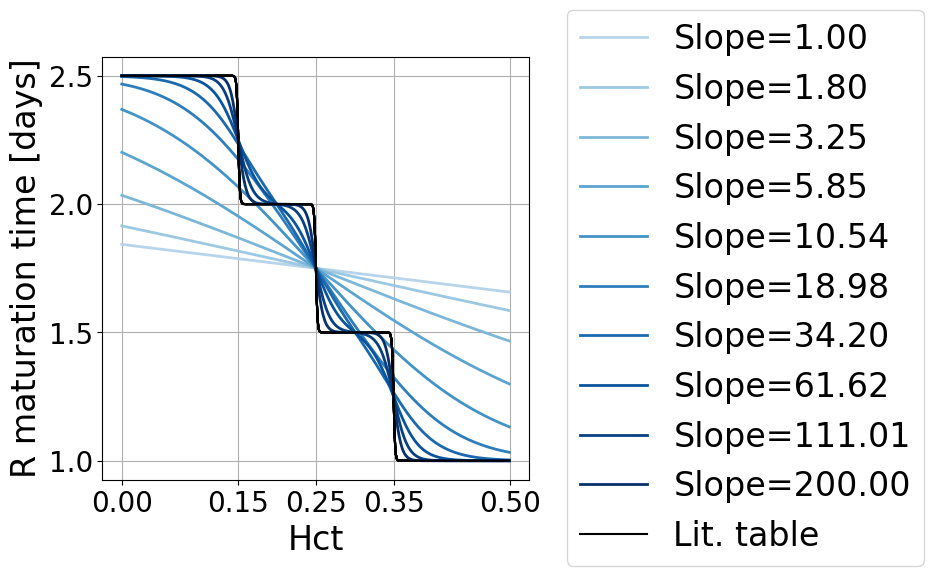

In [11]:
fig, ax = plt.subplots(figsize=(5.5,5.5)) 
# Farbübergang
cmap = plt.colormaps.get_cmap('Blues')
color_start = 0.3

slopes = convert_bounds_to_logscale({'slope':(1,200)})
print(slopes)
sloe_lst = np.linspace(slopes['slope'][0], slopes['slope'][1], 10)
#[1,2,3,4,5,10,20,30,40,100,200,300,500]
for idx,slope in enumerate(sloe_lst):
       color=cmap(color_start + idx * (00.8 / len(sloe_lst)))
       plot_logistic(ax, 10**slope, color)
       
handles, labels = ax.get_legend_handles_labels()  # Legend Box outsides Subplots
ax.legend(handles[::2]+handles[-1::], labels[::2]+labels[-1::], loc='upper left', 
                       bbox_to_anchor=(1.05, 1.15),fontsize= 24) #bbox (nach rechts-links, oben-unten, negativ yes)
plt.show()
fig.savefig('figures/matvsHct.pdf',bbox_inches='tight')

## Figure 2 Parameter scan

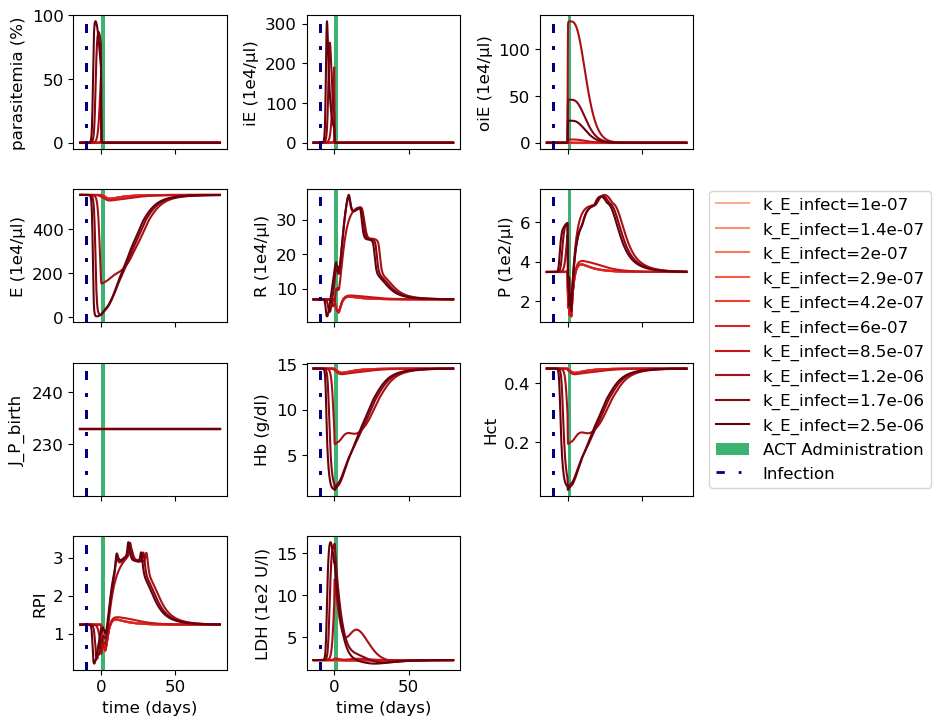

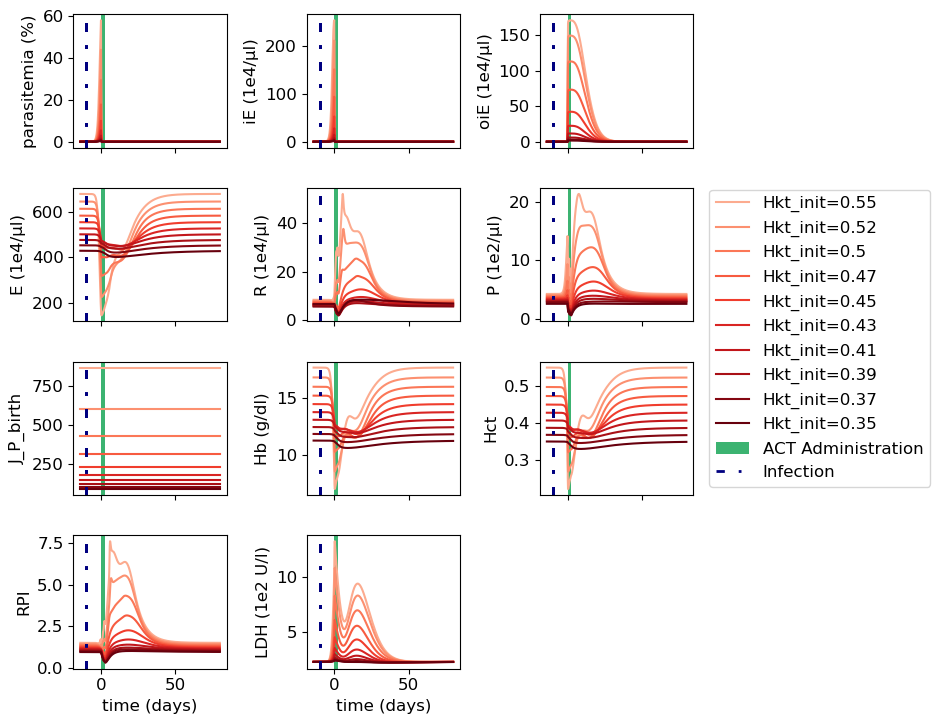

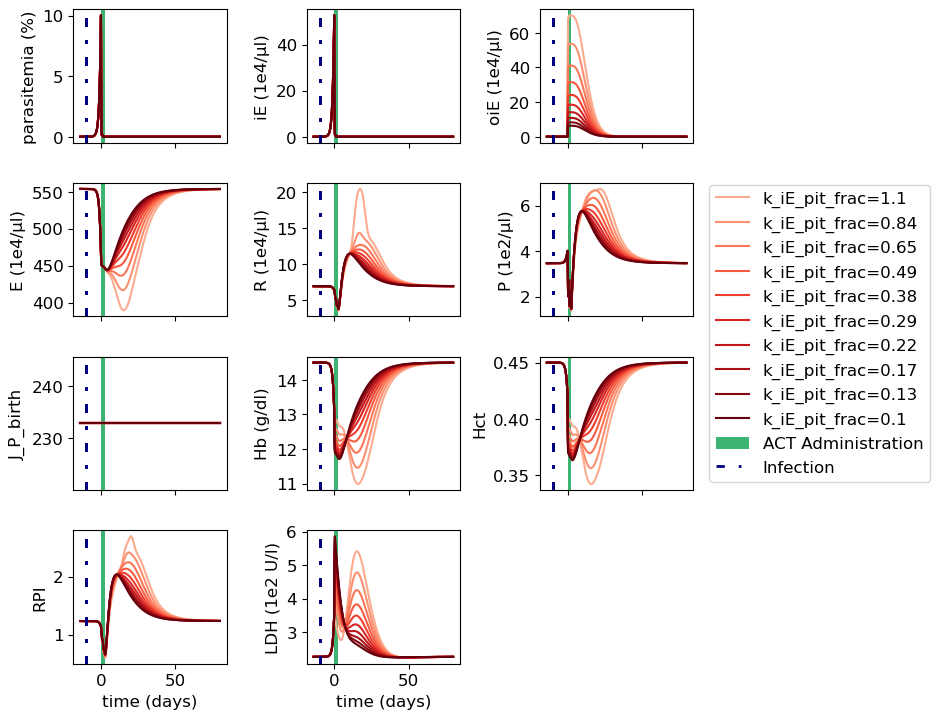

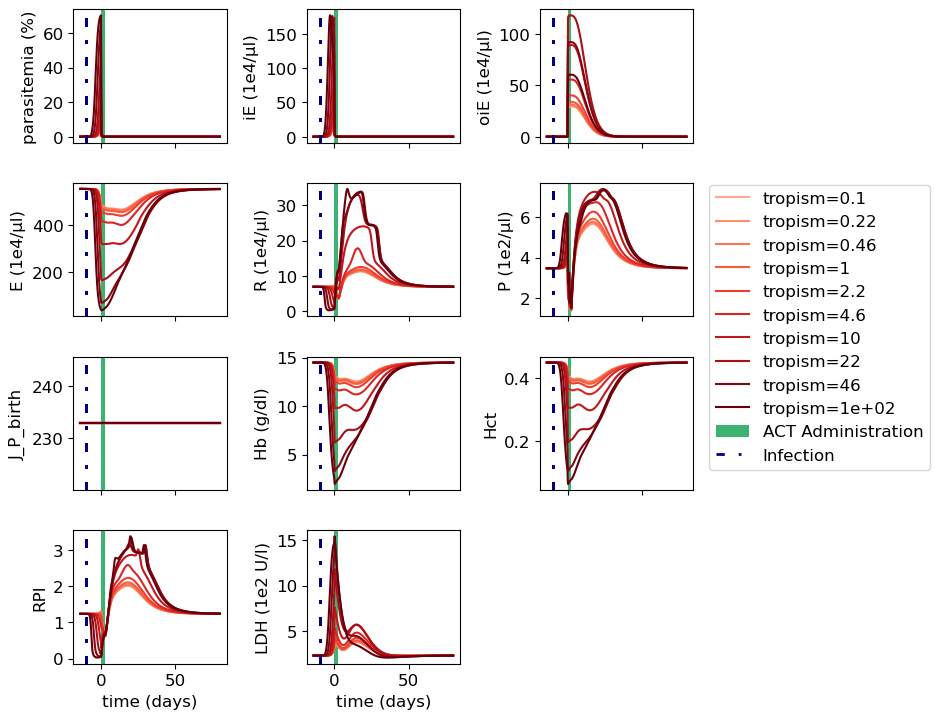

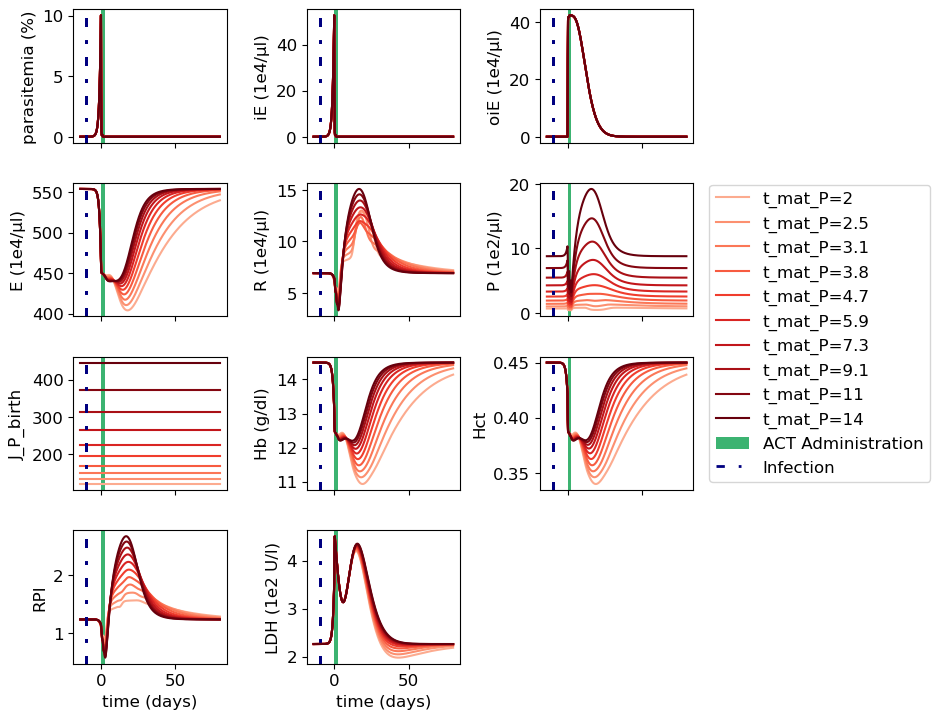

In [12]:
species_to_analyze = OrderedDict({
    'parasitemia' : ['parasitemia (%)', 1],
    '[iE]': ['iE (1e4/µl)', 1e4],
    'oiE': ['oiE (1e4/µl)', 1e4],
    '[E]': ['E (1e4/µl)', 1e4],
    '[R]': ['R (1e4/µl)', 1e4],
    '[P]': ['P (1e2/µl)', 1e2],
    'J_P_birth':['J_P_birth',1e0],
    'Hb': ['Hb (g/dl)', 1],
    'Hkt': ['Hct', 1],
    'RPI': ['RPI', 1],
    'LDH': ['LDH (1e2 U/l)',1e2],
})
# Possible Reti parameters to manipulate
# k_P_birth 295
# Definition der Parameter-Boundaries
params_bounds = OrderedDict({
    #'s_BH': (5e-7, 5e-6),
    'k_E_infect': (1e-7, 2.5e-6),
    "Hkt_init":(0.35,0.55),
    #'k_P_birth': (5e1, 1e3),
    #'slope_rpi':(1,200),      # own idea
    #'a_P_d':(1e4,6e8),
    #'k_M_death':(20,96),      # paper value 48 /day
    'k_iE_pit_frac': (0.1,1.1),
    
    'tropism': (0,100),
    
    't_mat_P':(2,14),        # medicine fact
    #'t_E_death':(70,130),
    #'r_P_d':(3,9.8),
    
})

pre_t = 10
update_parameters= {
        "k_E_infect": 2.052041851367283e-06,
        "tropism": 4.429542038768788,
        'k_M_death': 48,
        's_BH': 1.361151210723645e-06,          # only change here 
        "a_P_d": 59999.97948625444,
        "k_P_d": 0.0010000000517527397,
        "r_P_d": 5.870264855546418,
        "LDH": 197.37366622040253
}
update_pth= {
        "k_E_infect": 1.0351927708026337e-06,
        "tropism": 2.4824267001740767,
        "M": 100.0000740303447,
        "a_P_d": 9937191.134916836,
        "k_P_d": 0.009451056983160715,
        "r_P_d": 7.4265726002365495,
        "fac_R_d": 7.068386037799187e-10,
        "k_P_art_max": 2.709891804855283,
        "t_mat_P": 6.138028732895664,
        "k_iE_pit_frac": 0.6625125905514542,
        "t_E_death": 80.00000022727542,
        "s_BH": 7.105938524287848e-07, #change
        "LDH": 226.23256587878646,
        "k_M_death": 30.010891278063838
}
# Konvertiere bounds in logscale
params_bounds_log = convert_bounds_to_logscale(params_bounds)

# Anzahl der Werte pro Parameter 
num_values_per_param = 10

# Erzeugung der Wertemengen für jeden Parameter
param_values = {}
for param, bounds in params_bounds_log.items():
    param_values[param] = np.linspace(bounds[0], bounds[1], num_values_per_param)

# Farbübergang
cmap = plt.colormaps.get_cmap('Reds')
color_start = 0.3

for i, (param, values) in enumerate(param_values.items()):
    # Durchführung des Parameter-Scans und Erstellung der Plots
    cols = 3
    rows = int(np.ceil(len(species_to_analyze)/cols))   

    fig, axs = plt.subplots(rows,cols, figsize=(8,8.5), sharex=True)
    fig.subplots_adjust(hspace=0.3, wspace= 0.52)
    size_of_font = 12
    infection_dict = update_pth.copy()
    if param=='Hkt_init' or param=='k_iE_pit_frac':values=values[::-1]
    for idx, value in enumerate(values):

        infection_dict.update({param: 10**value})
        result = simulate_model(infection_pars=infection_dict, bool_med=True, bool_set_pars=True,
                                pre_t=pre_t, simulation_end=80, selections=['time']+list(species_to_analyze.keys()))	
        
        infection_dict.pop(param)
    
        # Plotting
        for j, specie in enumerate (species_to_analyze.keys()):

            row = j //3
            col = j % 3
            
            if specie in ['parasitemia','[iE]','oiE']:
                norm = result[specie]/result[specie].max()
            else: norm = result[specie]/result[specie].iloc[0]
            
            axs[row, col].plot(result['time'], result[specie]/species_to_analyze[specie][1], #norm,#
                               label=f'{param}={round(10**value,8):.2g}', 
                               color=cmap(color_start + idx * (00.8 / num_values_per_param)))
            #axs[row, col].set_xlabel('time (days)',fontsize= size_of_font)
            axs[row, col].set_ylabel(species_to_analyze[specie][0],fontsize= size_of_font)
            axs[row, col].tick_params(labelsize=size_of_font)

            axs[row, col].axvspan(0, 2.3, facecolor='mediumseagreen', alpha=1, label='ACT Administration')
            #axs[row, col].axvspan(1, 1.3, facecolor='mediumseagreen', alpha=1, )
            #axs[row, col].axvspan(2, 2.3, facecolor='mediumseagreen', alpha=1, )

            axs[row, col].axvline(-pre_t, color='navy', alpha=1, linewidth=2, linestyle=(0, (3, 5, 1, 5)), label='Infection')   
            axs[row, col].tick_params(bottom='on')   
            if row == 4 - 1:
                axs[row, col].set_xlabel('time (days)',fontsize= size_of_font)
            
        handles, labels = axs[-2, -2].get_legend_handles_labels()  # Legend Box outsides Subplots


    axs[-3, -1].legend(handles[::3]+handles[-2::], labels[::3]+labels[-2::], loc='upper left', 
                       bbox_to_anchor=(1.05, 1.05),fontsize= size_of_font) #bbox (nach rechts-links, oben-unten, negativ yes)

    
    axs.flat[-1].set_visible(False)
    #plt.savefig(f"figures/paramscan_{param}_short.pdf", format="pdf",bbox_inches='tight')
    #plt.tight_layout()
    plt.show()
    
#print(handles, labels)

#plt.savefig("plot.pdf")

In [14]:
import seaborn as sns
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

def t_relax(t,x):

    eq = get_steady_state(t,x)
    pos,h = find_peaks(x,eq)
    h = h["peak_heights"]
    A = np.abs((h - eq))
    A_i = np.argwhere(A < 0.01)
    
    if np.isfinite(eq) and A_i.shape[0] > 0:
        return t[pos[A_i[0,0]]]
    else:
        return np.inf
    

def get_steady_state(t,x):

    x_e = x[-int(0.1 * len(t)):]
    pos, h = find_peaks(x_e,np.mean(x_e) * 1.01)
    if len(pos) > 0:
        return np.inf
    else:
        return np.mean(x_e)

def max_rel_amplitude(t,x):

    eq = get_steady_state(t,x)
    if eq<=1e-6: eq=np.mean(x)
    pos,h = find_peaks(x,eq)
    if len(pos) == 0:
        return None,0
    i = np.argmax(h["peak_heights"])
    return pos[i], (h["peak_heights"][i] - eq)/eq


def max_abs_amplitude(t,x):
    n = 20 #rolling period
    local_max_vals = x.loc[x == x.rolling(n, center=True).max()]
    #df.loc[df[species] == df[species].rolling(n, center=True).min()]
    #print(local_max_vals)
    eq = get_steady_state(t,x)
    pos,h = find_peaks(x,eq)
    #print(pos, h)
    if len(pos) == 0:
        return None,0
    i = np.argmax(h["peak_heights"])
    return local_max_vals.max()#pos[i], h["peak_heights"][i]


def max_peak_width(t,x):
    #df.loc[df[species] == df[species].rolling(n, center=True).min()]
    #print(local_max_vals)
    eq = get_steady_state(t,x)
    pos,h = find_peaks(x,eq)

    #print(pos, h)
    if len(pos) == 0:
        return np.nan
    i = np.argmax(h["peak_heights"])
    local_max_vals = x.loc[0.95*h["peak_heights"][i]<x]
    return len(local_max_vals)#pos[i], h["peak_heights"][i]


def min_peak_width(t,x):
    n = 20 #rolling period
    x = x.reset_index(drop=True)
    local_min_vals = x.loc[x == x.rolling(n, center=True).min()]
    #df.loc[df[species] == df[species].rolling(n, center=True).min()]
    #print(local_min_vals)
    if len(local_min_vals)==0:
        return np.nan
    if local_min_vals.max()<=1e-6: return np.nan
    i = local_min_vals.idxmax()

    threshold = 1.05*local_min_vals.max()
    filtered_values =[]
    # Traverse left from the minimum value index
    left_index = i
    #print(x.iloc[left_index])
    while left_index >= 0 and x.iloc[left_index] <= threshold:
        filtered_values.append(left_index)
        left_index -= 1

    # Traverse right from the minimum value index
    right_index = i + 1
    while x.iloc[right_index] <= threshold:
        #print(x[right_index], threshold)
        filtered_values.append(right_index)
        right_index += 1
        if right_index == 510:break

    return len(filtered_values)#pos[i], h["peak_heights"][i]


def min_abs_amplitude(t,x):
    n = 20 #rolling period
    local_min_vals = x.loc[x == x.rolling(n, center=True).min()]
    if len(local_min_vals)==0:
        return np.nan
    if local_min_vals.max()<=1e-6: return [],None
    i = local_min_vals.idxmin()
    if len(local_min_vals) == 0:
        return None,0
    
    return i, local_min_vals.min()


def min_rel_amplitude(t,x):
    n = 20 #rolling period
    local_min_vals = x.loc[x == x.rolling(n, center=True).min()]
    if len(local_min_vals)==0:
        return np.nan
    eq = get_steady_state(t,x)
    if local_min_vals.max()<=1e-6: return np.nan
    i = local_min_vals.idxmin()
    if len(local_min_vals) == 0:
        return None,0
    print(local_min_vals)
    return i, (local_min_vals.min() -eq)/eq

    
def freq(t,x):

    eq = np.mean(x)
    pos,h = find_peaks(x,eq * 1.1)
    return 1/np.mean(np.diff(t[pos]))

def t_relax_smooth(t,x):
    eq = get_steady_state(t,x)
    def g(x,a,tau):
        return a * np.exp(-1/tau*x) + eq

    pos,h = find_peaks(x,eq)
    if len(pos) <= 1:
        return np.inf
    popt,pcov = curve_fit(g,x[pos],h["peak_heights"])
    if pcov[1,1]**2 > 1:
        return np.inf
        
    return popt[1]

from functools import reduce


def my_find_peaks(X,n=200,eps = 0.01):

    max_peaks = []
    min_peaks = []
    def p(x):

        x = (x - np.min(x))
        pos,h = find_peaks(x,eps)
        if len(pos)>0:
            max_peaks.append((x.index[pos].astype(int).tolist()))
            
        x = -x
        x = (x - np.min(x))
        pos,h = find_peaks(x, eps)
        if len(pos)>0:
            min_peaks.append((x.index[pos].astype(int).tolist()))

        return 1

    X.rolling(n, center=True).apply(p)
    try:
        max_peaks = reduce(lambda a,b: a+b, max_peaks)
        max_peaks = np.unique(max_peaks)
    except TypeError:pass

    try:
        min_peaks = reduce(lambda a,b: a+b, min_peaks)
        min_peaks = np.unique(min_peaks)    
    except TypeError:pass


    return min_peaks,max_peaks


def peak_width(x, loc:list=[], type:str='max'):
 
    if len(loc)==0:
        return np.nan
    loc = int(loc[0])

    if x[loc]<=1e-6: return np.nan
    
    threshold = 1.01*x[loc]
    if type=='max': 
        x =-x
        threshold = .95*x[loc] 
        
    filtered_values =[]
    # Traverse left from the minimum value index
    left_index = loc
    while left_index >= 0 and x[left_index] <= threshold:
        filtered_values.append(left_index)
        left_index -= 1

    # Traverse right from the minimum value index
    right_index = loc + 1
    while right_index< len(x) and x[right_index] <= threshold:
        #print(x[right_index], threshold)
        filtered_values.append(right_index)
        right_index += 1

    return len(filtered_values)

def new_max_peaks(t,x):
    
    x.index = pd.RangeIndex(len(x))    
    t.index = pd.RangeIndex(len(x))    

    min_peaks,max_peaks = my_find_peaks(x)

    result = {
        "maximum_magnitude":{f"peak_{i}":float(x.loc[loc]) for i,loc in enumerate(max_peaks)},
        "maximum_timepoint":{f"peak_{i}":float(t.loc[loc]) for i,loc in enumerate(max_peaks)},
        "maximum_width":{f"peak_{i}":float(peak_width(x,[loc],type='max')) for i,loc in enumerate(max_peaks)},
        
        "minimum_magnitude":{f"peak_{i}":float(x.loc[loc]) for i,loc in enumerate(min_peaks)},
        "minimum_timepoint":{f"peak_{i}":float(t.loc[loc]) for i,loc in enumerate(min_peaks)},
        "minimum_width":{f"peak_{i}":float(peak_width(x,[loc],type='min')) for i,loc in enumerate(min_peaks)},
    }
    return result


readouts = {
    #"frequency":freq,# mean frequency of oscillations that exceed the mean by 10%
    #"mean":lambda t,x:np.mean(x), # mean value
    'maximum_height': new_max_peaks,
    #'max_peak_width': lambda t,x: max_peak_width(t,x),
    #'min_peak_width': lambda t,x: min_peak_width(t,x),
    #"steady_state":lambda t,x: get_steady_state(t,x), # steady state value if solutin is non oscillatory
    #"max_rel_amplitude":lambda t,x: max_rel_amplitude(t,x)[1], # maximum peak amplitude as a multiple of the steady state
    #"max_abs_amplitude":lambda t,x: max_abs_amplitude(t,x), # max peak amplitude from 0

    #"min_rel_amplitude":lambda t,x: min_rel_amplitude(t,x), # maximum peak amplitude as a multiple of the steady state
    #"min_abs_amplitude":lambda t,x: min_abs_amplitude(t,x), # maximum peak amplitude as a multiple of the steady state

    #"t_relax":t_relax, # time until osciallations die out
    #"tau":lambda x,t: t_relax_smooth(x,t)# decay constant of the enveloping exponential function
}
tester = result.div(result.iloc[0])
tester = tester.drop(['time'],axis=1)
tester[['parasitemia', '[iE]', 'oiE']] = result[['parasitemia', '[iE]', 'oiE']]        
for species in result.columns[1:]:
    print(species)
    for k,v in readouts.items():
        try:
            print(k, f"{v(result['time'], tester[species]):.2f}")
        except:
            print(k,v(result['time'], tester[species]))
df = []
update_pth= {
        "k_E_infect": 1.0351927708026337e-06,
        "tropism": 2.4824267001740767,
        "M": 100.0000740303447,
        "a_P_d": 9937191.134916836,
        "k_P_d": 0.009451056983160715,
        "r_P_d": 7.4265726002365495,
        "fac_R_d": 7.068386037799187e-10,
        "k_P_art_max": 2.709891804855283,
        "t_mat_P": 6.138028732895664,
        "k_iE_pit_frac": 0.6625125905514542,
        "t_E_death": 80.00000022727542,
        "s_BH": 7.105938524287848e-07, #change
        "LDH": 226.23256587878646,
        "k_M_death": 30.010891278063838
}
params_bounds = OrderedDict({
    's_BH': (5e-7, 5e-6),
    #'k_E_infect': (1e-7, 2.5e-6),
    #"Hkt_init":(0.35,0.55),
    #'slope_rpi':(1,200),      # own idea
    #'a_P_d':(1e4,6e8),
    #'k_M_death':(20,96),      # paper value 48 /day
    #'k_iE_pit_frac': (0.1,1.1),
    #'tropism': (0,100),
    #'t_mat_P':(2,14),        # medicine fact
    #'t_E_death':(70,130),

    #'r_P_d':(3,9.8),
    #'k_P_birth': (5e1, 1e3),
    
})
for p_name, p_value in update_pth.items():
    if not p_name in params_bounds.keys(): continue
    infection_dict = update_pth.copy()
    for m in np.logspace(-.1,.1,30):
        result = simulate_model(infection_pars= infection_dict | {p_name:update_pth[p_name]*m}, bool_med=True, bool_set_pars=True, 
                                pre_t=pre_t, simulation_end=80,selections=['time']+list(species_to_analyze.keys()))

        t = result['time']

        tester = result.div(result.iloc[0])
        tester = tester.drop(['time'],axis=1)
        tester[['parasitemia', '[iE]', 'oiE']] = result[['parasitemia', '[iE]', 'oiE']]      

        for species in result.columns[1:]:
            y = tester[species]
            for k,v in readouts.items():
                r = v(t,y)
                
                if isinstance(r,dict):
                    for sub_k,sub_r in r.items():
                        if isinstance(sub_r,dict):
                            for sub_sub_k,sub_sub_r in sub_r.items():
                                df.append({"readout_name":sub_k,"value":sub_sub_r,"sub_readout_name":sub_sub_k} | {"parameter":p_name, "parameter_value":m,"species":species})    
                        else:
                            df.append({"readout_name":k,"value":sub_r,"sub_readout_name":sub_k} | {"parameter":p_name, "parameter_value":m,"species":species})
                else:
                    try:
                        r = float(r)
                    except:continue
                    df.append({"readout_name":k,"value":r} | {"parameter":p_name, "parameter_value":m,"species":species})
df = pd.DataFrame(df)

parasitemia
maximum_height {'maximum_magnitude': {'peak_0': 10.022994087362193, 'peak_1': 0.15631174455454497}, 'maximum_timepoint': {'peak_0': -0.09999999999999964, 'peak_1': 0.9800000000000004}, 'maximum_width': {'peak_0': 1.0, 'peak_1': 1.0}, 'minimum_magnitude': {'peak_0': 0.11840894554416836}, 'minimum_timepoint': {'peak_0': 0.6199999999999992}, 'minimum_width': {'peak_0': 1.0}}
[iE]
maximum_height {'maximum_magnitude': {'peak_0': 527266.8270453261, 'peak_1': 7768.8742306060785}, 'maximum_timepoint': {'peak_0': -0.09999999999999964, 'peak_1': 0.9800000000000004}, 'maximum_width': {'peak_0': 1.0, 'peak_1': 1.0}, 'minimum_magnitude': {'peak_0': 5892.643158972029}, 'minimum_timepoint': {'peak_0': 0.6199999999999992}, 'minimum_width': {'peak_0': 1.0}}
oiE
maximum_height {'maximum_magnitude': {'peak_0': 422912.638742509}, 'maximum_timepoint': {'peak_0': 1.5199999999999996}, 'maximum_width': {'peak_0': 32.0}, 'minimum_magnitude': {}, 'minimum_timepoint': {}, 'minimum_width': {}}
[E]
max

In [15]:
def test_profile():
    update_pth= {
        "k_E_infect": 1.0351927708026337e-06,
        "tropism": 2.4824267001740767,
        "M": 100.0000740303447,
        "a_P_d": 9937191.134916836,
        "k_P_d": 0.009451056983160715,
        "r_P_d": 7.4265726002365495,
        "fac_R_d": 7.068386037799187e-10,
        "k_P_art_max": 2.709891804855283,
        "t_mat_P": 6.138028732895664,
        "k_iE_pit_frac": 0.6625125905514542,
        "t_E_death": 80.00000022727542,
        "s_BH": 7.105938524287848e-07, #change
        "LDH": 226.23256587878646,
        "k_M_death": 30.010891278063838}     
    params_bounds = OrderedDict({
        's_BH': (5e-7, 5e-6),
        #'k_E_infect': (1e-7, 2.5e-6),
        #"Hkt_init":(0.35,0.55),
        #'slope_rpi':(1,200),      # own idea
        #'a_P_d':(1e4,6e8),
        #'k_M_death':(20,96),      # paper value 48 /day
        #'k_iE_pit_frac': (0.1,1.1),
        #'tropism': (0,100),
        #'t_mat_P':(2,14),        # medicine fact
        #'t_E_death':(70,130),

        #'r_P_d':(3,9.8),
        #'k_P_birth': (5e1, 1e3),
        
    })
    df = []
    for p_name, p_value in update_pth.items():
        if not p_name in params_bounds.keys(): continue
        infection_dict = update_pth.copy()
        for m in np.logspace(-1,1,30):
            result = simulate_model(infection_pars= infection_dict | {p_name:update_pth[p_name]*m}, bool_med=True, bool_set_pars=True, 
                                    pre_t=pre_t, simulation_end=80,selections=['time']+list(species_to_analyze.keys()))

            t = result['time']

            tester = result.div(result.iloc[0])
            tester = tester.drop(['time'],axis=1)
            tester[['parasitemia', '[iE]', 'oiE']] = result[['parasitemia', '[iE]', 'oiE']]      

            for species in result.columns[1:]:
                y = tester[species]
                for k,v in readouts.items():
                    r = v(t,y)
                    if isinstance(r,dict):
                        for sub_k,sub_r in r.items():
                            if isinstance(sub_r,dict):
                                for sub_sub_k,sub_sub_r in sub_r.items():
                                    df.append({"readout_name":sub_k,"value":sub_sub_r,"sub_readout_name":sub_sub_k} | {"parameter":p_name, "parameter_value":m,"species":species})    
                            else:
                                df.append({"readout_name":k,"value":sub_r,"sub_readout_name":sub_k} | {"parameter":p_name, "parameter_value":m,"species":species})
                    else:
                        try:
                            r = float(r)
                        except:continue
                        df.append({"readout_name":k,"value":r} | {"parameter":p_name, "parameter_value":m,"species":species})

# %lprun -f my_find_peaks test_profile()

In [16]:
df.groupby(["readout_name","species","parameter"]).nunique()

value  sub_readout_name  \
readout_name      species     parameter                            
maximum_magnitude Hb          s_BH          30                 1   
                  Hkt         s_BH          30                 1   
                  LDH         s_BH          60                 2   
                  RPI         s_BH          60                 2   
                  [E]         s_BH           5                 1   
                  [P]         s_BH          91                 4   
                  [R]         s_BH          60                 2   
                  [iE]        s_BH          31                 2   
                  oiE         s_BH          30                 1   
                  parasitemia s_BH          31                 2   
maximum_timepoint Hb          s_BH          12                 1   
                  Hkt         s_BH          12                 1   
                  LDH         s_BH           3                 2   
                  RPI         s_BH           7                 2   
                  [E]         s_BH           5                 1   
                  [P]         s_BH          14                 4   
                  [R]         s_BH           9                 2   
                  [iE]        s_BH           2                 2   
                  oiE         s_BH           1                 1   
                  parasitemia s_BH           2                 2   
maximum_width     Hb          s_BH           9                 1   
                  Hkt         s_BH           9                 1   
                  LDH         s_BH           6                 2   
                  RPI         s_BH          15                 2   
                  [E]         s_BH           1                 1   
                  [P]         s_BH          10                 4   
                  [R]         s_BH          19                 2   
                  [iE]        s_BH           1                 2   
                  oiE         s_BH           1                 1   
                  parasitemia s_BH           1                 2   
minimum_magnitude Hb          s_BH          60                 2   
                  Hkt         s_BH          60                 2   
                  LDH         s_BH          60                 2   
                  RPI         s_BH          60                 2   
                  [E]         s_BH          47                 2   
                  [P]         s_BH          90                 3   
                  [R]         s_BH          60                 2   
                  [iE]        s_BH          30                 1   
                  parasitemia s_BH          30                 1   
minimum_timepoint Hb          s_BH           9                 2   
                  Hkt         s_BH           9                 2   
                  LDH         s_BH           6                 2   
                  RPI         s_BH           2                 2   
                  [E]         s_BH          22                 2   
                  [P]         s_BH           3                 3   
                  [R]         s_BH           2                 2   
                  [iE]        s_BH           1                 1   
                  parasitemia s_BH           1                 1   
minimum_width     Hb          s_BH          38                 2   
                  Hkt         s_BH          35                 2   
                  LDH         s_BH           9                 2   
                  RPI         s_BH           1                 2   
                  [E]         s_BH          33                 2   
                  [P]         s_BH           1                 3   
                  [R]         s_BH           1                 2   
                  [iE]        s_BH           1                 1   
                  parasitemia s_BH           1                 1   

                            

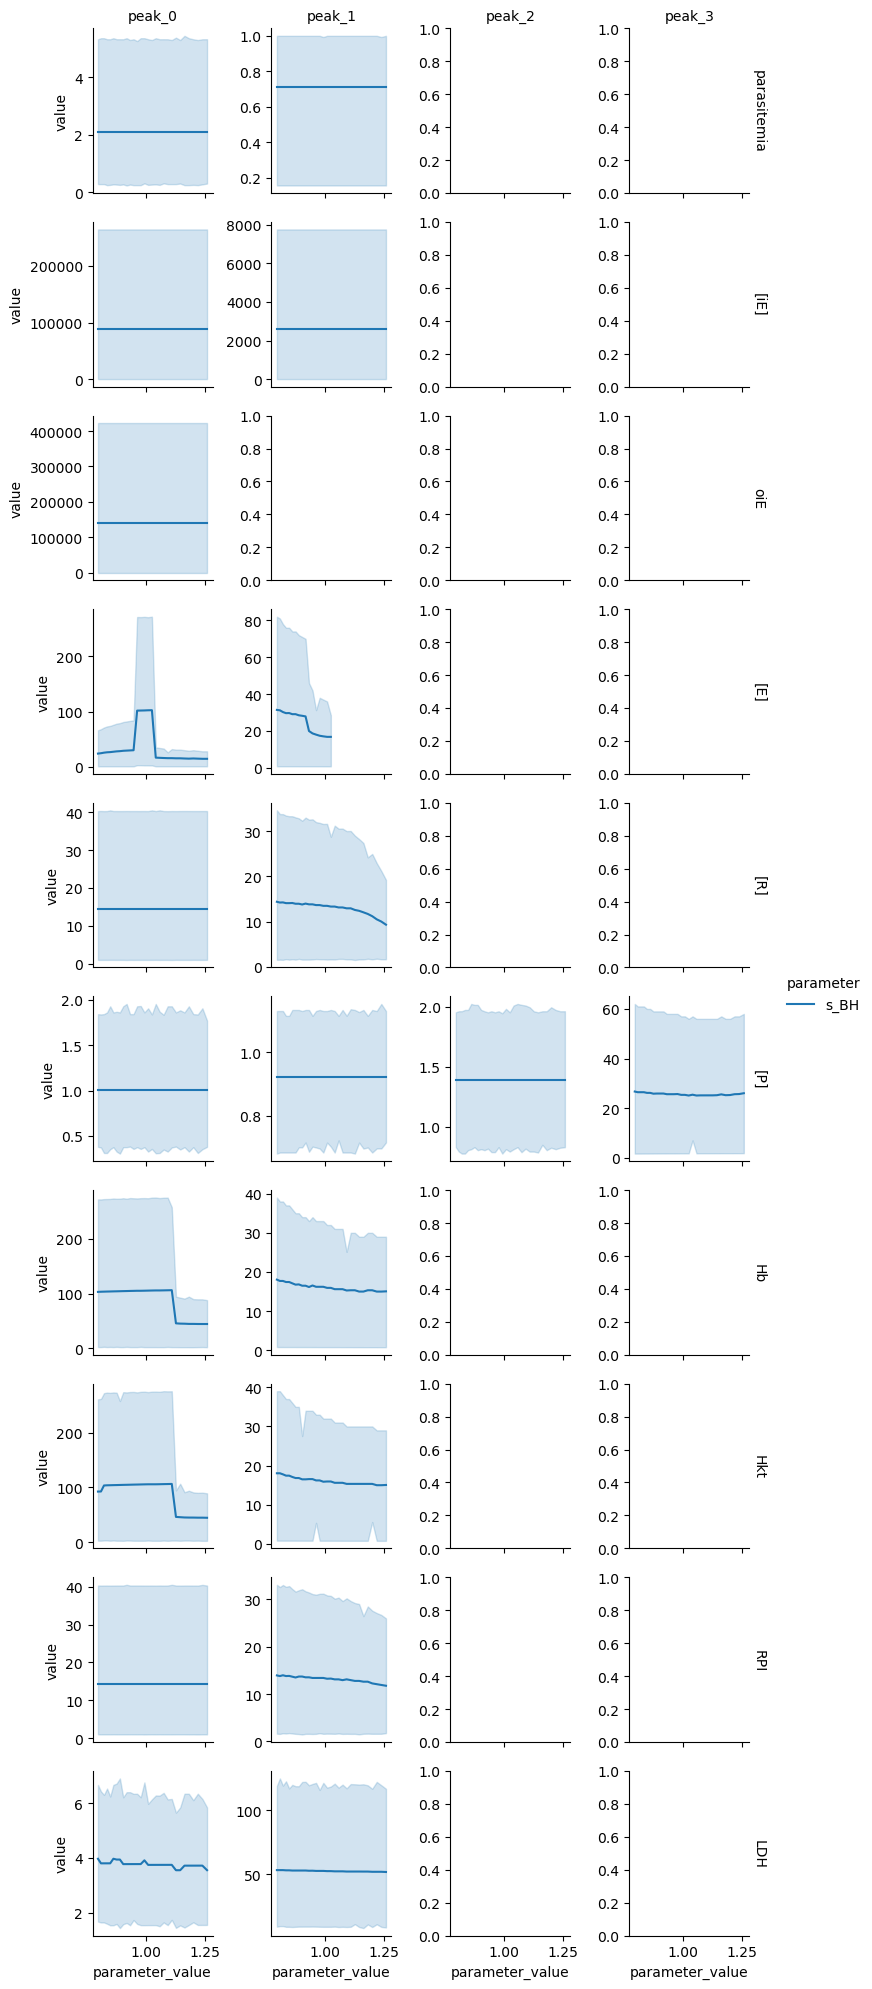

In [17]:
f = lambda df:df.loc[df["parameter"].isin(["Hkt_init", 'tropism', 't_mat_P'])]
g = sns.FacetGrid(df.dropna(), col = "sub_readout_name",row ="species",
                    hue = "parameter",
                    sharey = False,
                    sharex = True,
                    height = 2,
                    margin_titles = True,
                    palette="tab10"                    
                    )
g.map(sns.lineplot, "parameter_value","value")
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

g.add_legend()

In [18]:
def my_filter(df):

    #sdf = df.loc[df["readout_name"] == "minimum_magniutude"]
    sdf = df.loc[df["readout_name"] == "maxium_magnitude"]
    if len(sdf) == 0:
        return pd.DataFrame(columns=df.columns)
    #srn = sdf.loc[sdf["value"].idxmin(),"sub_readout_name"]
    srn = sdf.loc[sdf["value"].idxmax(),"sub_readout_name"]
    #print(srn)
    #print(df.loc[df["sub_readout_name"] == srn]["readout_name"].unique())

    return df.loc[df["sub_readout_name"] == srn]


sub_df = df.groupby(df.columns.drop(["readout_name","sub_readout_name","value"],).tolist(),as_index = False).apply(my_filter)
sub_df

,,readout_name,value,sub_readout_name,parameter,parameter_value,species


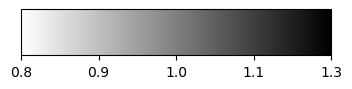

In [19]:
from matplotlib.colors import LinearSegmentedColormap as lsc
from matplotlib.cm import ScalarMappable
from colorsys import rgb_to_hsv,hsv_to_rgb
color = (0.5,0.5,0.5)

color_start = list(rgb_to_hsv(*color))
color_start[1] = 0
color_start[2] = 1
color_start = hsv_to_rgb(*color_start)

color_end = list(rgb_to_hsv(*color))
color_end[2] = 0.0*color_end[2]
color_end = hsv_to_rgb(*color_end)

cmap = lsc.from_list('ai',[color_start,color,color_end])
m = np.logspace(-.1,.1,10)
norm = plt.Normalize(vmin = np.log10(m[0]),vmax = np.log10(m[-1]))
sm = ScalarMappable(norm=norm, cmap=cmap)

plt.figure(figsize=(4,0.6))
cbar = fig.colorbar(sm,cax=plt.gca(), location = "bottom",)
xticks = cbar.get_ticks()
xticks = [round(10**x,1) for x in xticks]
cbar.set_ticklabels(xticks)

In [20]:
df

,readout_name,value,sub_readout_name,parameter,parameter_value,species
0,maximum_magnitude,10.019990,peak_0,s_BH,0.794328,parasitemia
1,maximum_magnitude,0.156146,peak_1,s_BH,0.794328,parasitemia
2,maximum_timepoint,-0.100000,peak_0,s_BH,0.794328,parasitemia
3,maximum_timepoint,0.980000,peak_1,s_BH,0.794328,parasitemia
4,maximum_width,1.000000,peak_0,s_BH,0.794328,parasitemia
...,...,...,...,...,...,...
3031,minimum_magnitude,0.990559,peak_1,s_BH,1.258925,LDH
3032,minimum_timepoint,5.660000,peak_0,s_BH,1.258925,LDH
3033,minimum_timepoint,49.580000,peak_1,s_BH,1.258925,LDH
3034,minimum_width,8.000000,peak_0,s_BH,1.258925,LDH


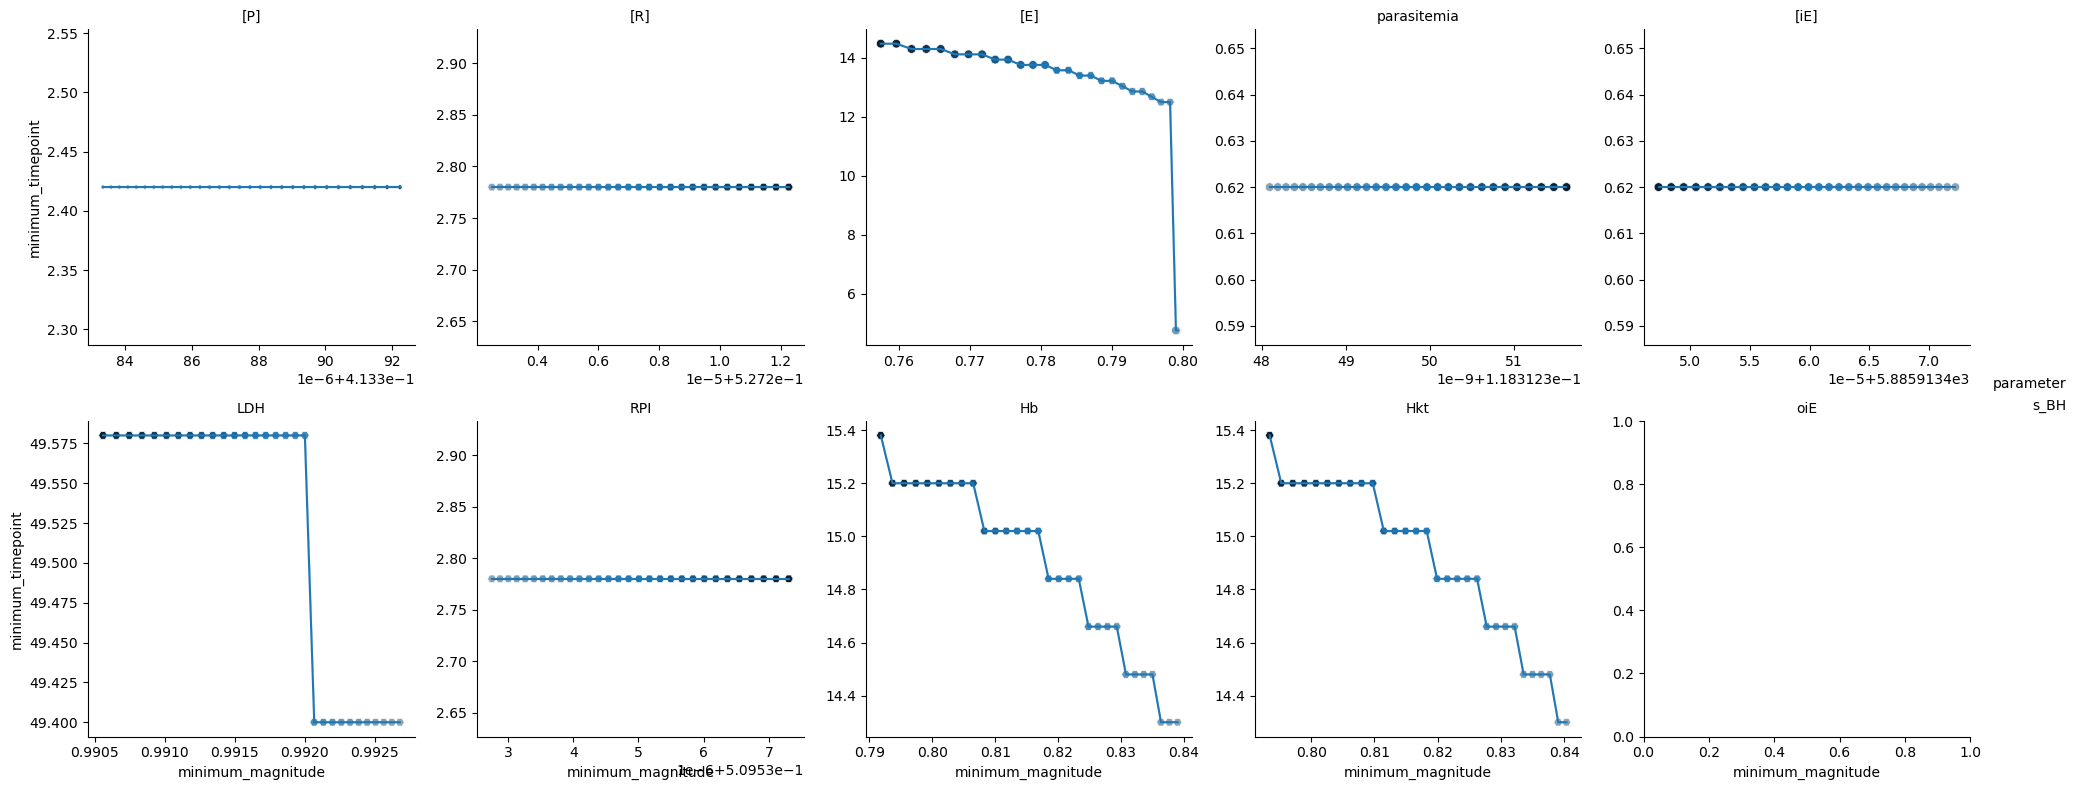

In [21]:
def create_cm(color):
    color_start = list(rgb_to_hsv(*color))
    color_start[1] = 0.25*color_start[1]
    color_start = hsv_to_rgb(*color_start)

    color_end = list(rgb_to_hsv(*color))
    color_end[2] = .25*color_end[2]
    color_end = hsv_to_rgb(*color_end)

    return lsc.from_list('ai',[color_start,color,color_end])


def my_scatter(*args, data = None,color = None,label = None,):
   
    peaks = data[["parameter_value",'sub_readout_name']]

    df = data.pivot(columns=["readout_name"],index = "parameter_value",values = "value")
    df = df.merge(peaks,on = "parameter_value")
    df.sort_index(inplace=True)
    sns.lineplot(data = df, x=args[0],y=args[1], #style = "sub_readout_name",
                color=color)
    
    own_cm = create_cm(color)
    sns.scatterplot(data = df, x=args[0],y=args[1], style = "sub_readout_name",
                    hue="parameter_value", palette=own_cm,
                    s = 40,markers={"peak_5":"p",
                                    "peak_1":"H",
                                    "peak_2":".",
                                    "peak_3":"^",
                                    "peak_4":">",
                                    "peak_0":"o",
                                    "peak_6":"o",
                                    "peak_7":"o",}
                    )


def my_filter(df, col=None):

    sdf = df.loc[df["readout_name"] == col]
    #sdf = df.loc[df["readout_name"] == "maxium_magnitude"]
    if len(sdf) == 0:
        return pd.DataFrame(columns=df.columns)
    srn = sdf.loc[sdf["value"].idxmin(),"sub_readout_name"]
    #print(df.loc[df["sub_readout_name"] == srn]["readout_name"].unique())

    return df.loc[df["sub_readout_name"] == srn]


sub_df = df.groupby(df.columns.drop(["readout_name","sub_readout_name","value"],).tolist(),as_index = False).apply(my_filter, col='minimum_magnitude')


g = sns.FacetGrid(sub_df.dropna(), col = "species",col_wrap=5,
                    hue = "parameter",
                    sharey = False,
                    sharex = False,
                    height = 4,
                    margin_titles = True,
                    palette="tab10",
                    col_order=['[P]','[R]','[E]','parasitemia','[iE]','LDH','RPI','Hb','Hkt','oiE']                    
                    )
g.map_dataframe(my_scatter, 'minimum_magnitude','minimum_timepoint')
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

g.add_legend()

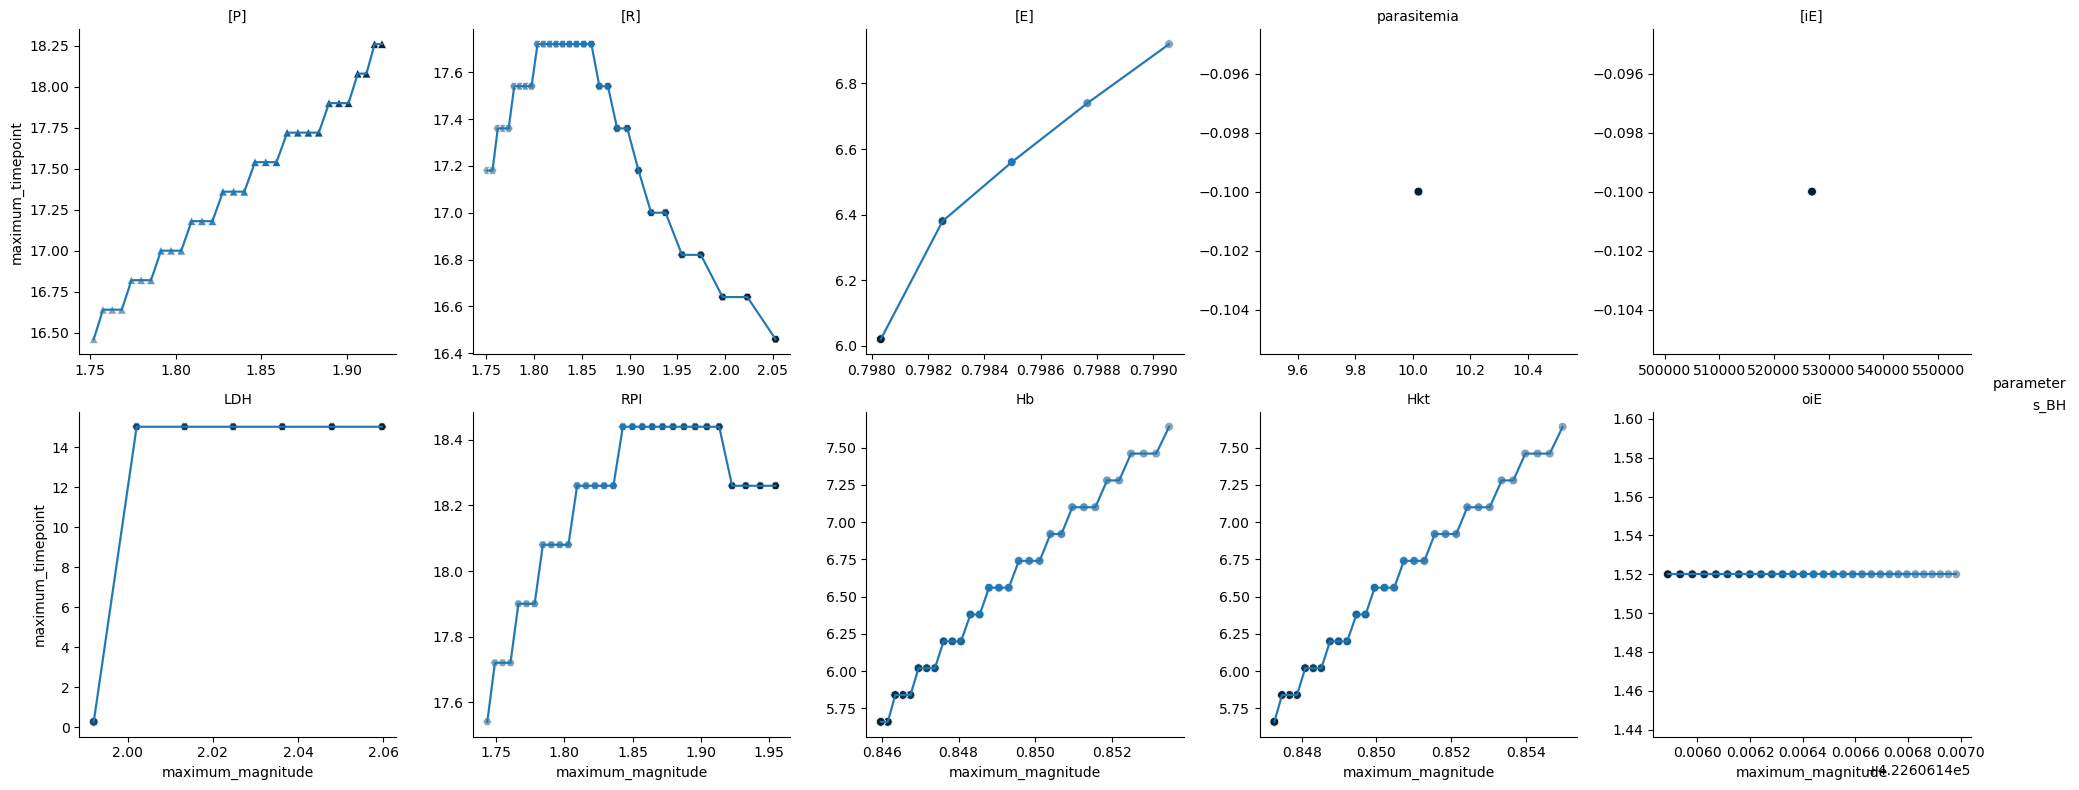

In [22]:

def my_scatter(*args, data = None,color = None,label = None,):
   
    peaks = data[["parameter_value",'sub_readout_name']]

    df = data.pivot(columns=["readout_name"],index = "parameter_value",values = "value")
    df = df.merge(peaks,on = "parameter_value")
    df.sort_index(inplace=True)
    sns.lineplot(data = df, x = args[0],y =args[1], #style = "sub_readout_name",
                color=color)
    
    own_cm = create_cm(color)
    sns.scatterplot(data = df, x = args[0],y =args[1], style = "sub_readout_name",
                    hue="parameter_value", palette=own_cm,
                    s = 40,markers={"peak_5":"p",
                                    "peak_1":"H",
                                    "peak_2":".",
                                    "peak_3":"^",
                                    "peak_4":">",
                                    "peak_0":"o",
                                    "peak_6":"o",
                                    "peak_7":"o",}
                    )

f = lambda df:df.copy()#df.loc[df["species"].isin(["[P]"])]

def my_filter(df, type):

    sdf = df.loc[df["readout_name"] == f"{type}imum_magnitude"]

    if len(sdf) == 0:
        return pd.DataFrame(columns=df.columns)
    if type=='min':
        srn = sdf.loc[sdf["value"].idxmin(),"sub_readout_name"]
    else:
        srn = sdf.loc[sdf["value"].idxmax(),"sub_readout_name"]
    #print(df.loc[df["sub_readout_name"] == srn]["readout_name"].unique())

    return df.loc[df["sub_readout_name"] == srn]

looker='max'
sub_df = df.groupby(df.columns.drop(["readout_name","sub_readout_name","value"],).tolist(),as_index = False).apply(my_filter,looker)

g = sns.FacetGrid(sub_df.dropna(), col = "species",col_wrap=5,
                    hue = "parameter",
                    sharey = False,
                    sharex = False,
                    height = 4,
                    margin_titles = True,
                    palette="tab10",
                    col_order=['[P]','[R]','[E]','parasitemia','[iE]','LDH','RPI','Hb','Hkt','oiE']                    
                    )
g.map_dataframe(my_scatter,f"{looker}imum_magnitude",f"{looker}imum_timepoint")
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

g.add_legend()

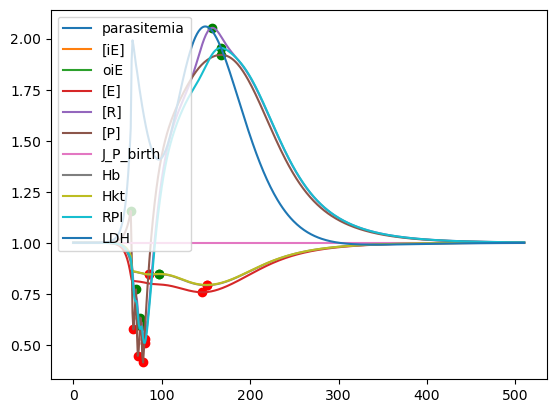

In [23]:
df = (result.div(result.iloc[0]))
df = df.drop(['time'],axis=1)
#df[['parasitemia', '[iE]', 'oiE']] = result[['parasitemia', '[iE]', 'oiE']]        
df = df.reset_index(drop=True)
# Find local peaks
n = 5 #rolling period
df.plot()
for species in result.columns[1:]:
    if species=='J_P_birth':continue
    local_min_vals = df.loc[df[species] == df[species].rolling(n, center=True).min()]
    local_max_vals = df.loc[df[species] == df[species].rolling(n, center=True).max()]
    if species=="LDH":
        continue
        #print(len(df))
        #print(min_rel_amplitude(result['time'], df['LDH']))
        #print(min_rel_amplitude(result['time'], df['RPI']*-1))

    local_max_vals[species] = local_max_vals[species].loc[local_max_vals[species]!=1.0].dropna()
    local_min_vals[species] = local_min_vals[species].loc[local_min_vals[species]!=1.0].dropna()
    #print(local_min_vals[species].loc[local_min_vals[species]!=1.0].dropna())
    plt.scatter(local_max_vals.index,local_max_vals[species], c='g')
    plt.scatter(local_min_vals.index,local_min_vals[species], c='r')


In [24]:
result

,time,parasitemia,[iE],oiE,[E],[R],[P],J_P_birth,Hb,Hkt,RPI,LDH
0,-14.000000,0.000000e+00,0.000000e+00,0.000000,5.538462e+06,69230.769038,347.372735,232.819941,14.496923,0.450000,1.234568,226.232566
1,-13.555556,0.000000e+00,0.000000e+00,0.000000,5.538462e+06,69230.769038,347.372735,232.819941,14.496923,0.450000,1.234568,226.232566
2,-13.111111,0.000000e+00,0.000000e+00,0.000000,5.538462e+06,69230.769038,347.372735,232.819941,14.496923,0.450000,1.234568,226.232566
3,-12.666667,0.000000e+00,0.000000e+00,0.000000,5.538462e+06,69230.769038,347.372735,232.819941,14.496923,0.450000,1.234568,226.232566
4,-12.222222,0.000000e+00,0.000000e+00,0.000000,5.538462e+06,69230.769038,347.372735,232.819941,14.496923,0.450000,1.234568,226.232566
...,...,...,...,...,...,...,...,...,...,...,...,...
496,79.280000,9.585313e-30,5.373256e-25,0.000118,5.536349e+06,69368.869824,348.011655,232.819941,14.491886,0.449845,1.237040,226.023841
497,79.460000,8.461229e-30,4.743158e-25,0.000110,5.536389e+06,69366.209596,347.999350,232.819941,14.491983,0.449848,1.236992,226.027626
498,79.640000,7.469145e-30,4.187048e-25,0.000103,5.536429e+06,69363.600719,347.987282,232.819941,14.492078,0.449851,1.236945,226.031345
499,79.820000,6.593320e-30,3.696103e-25,0.000096,5.536468e+06,69361.042199,347.975447,232.819941,14.492171,0.449854,1.236899,226.035000


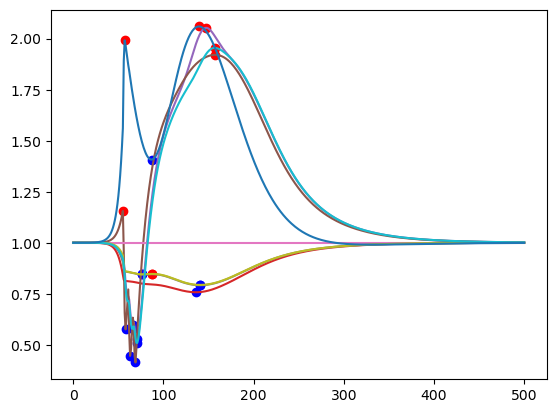

In [25]:
from functools import reduce


def my_find_peaks(X,n=50,eps = 0.01):

    max_peaks = []
    min_peaks = []
    def p(x):
        quantil = 0.6
        x = (x - np.quantile(x,quantil))
        pos,h = find_peaks(x,eps)
        if len(pos)>0:
            max_peaks.append((x.index[pos].astype(int).tolist()))
            
        x = -x
        x = (x - np.quantile(x,quantil))
        pos,h = find_peaks(x, eps)
        if len(pos)>0:
            min_peaks.append((x.index[pos].astype(int).tolist()))

        return 1

    X.rolling(n, center=True).apply(p)
    try:
        max_peaks = reduce(lambda a,b: a+b, max_peaks)
        max_peaks = np.unique(max_peaks)
    except TypeError:pass

    try:
        min_peaks = reduce(lambda a,b: a+b, min_peaks)
        min_peaks = np.unique(min_peaks)    
    except TypeError:pass


    return min_peaks,max_peaks


df = result.div(result.iloc[0])
for S in df.columns[1:]:
#for S in ["Hkt"]:
    min_peaks,max_peaks = [],[]

    X = df[S]
    plt.plot(X)
    min_peaks,max_peaks = my_find_peaks(X, n = 100,eps = .01)

    plt.scatter(min_peaks,X.loc[min_peaks],color = "blue")
    plt.scatter(max_peaks,X.loc[max_peaks], color = "red")

#plt.plot(df['Hkt'].loc[df['Hkt'] == df['Hkt'].rolling(n, center=True).find_peaks(,eq)])
#print(df['Hkt'].loc[df['Hkt'] == df['Hkt'].rolling(n, center=True).min()])
#plt.xlim([70,120])

In [26]:
def plot_extrem_points(ax,X,time, n:int = 100, eps=0.01):
    min_peaks,max_peaks = [],[]

    min_peaks,max_peaks = my_find_peaks(X, n = n,eps = eps)

    ax.scatter(time.loc[min_peaks],X.loc[min_peaks],color = "blue")
    ax.scatter(time.loc[max_peaks],X.loc[max_peaks], color = "red")

    return ax

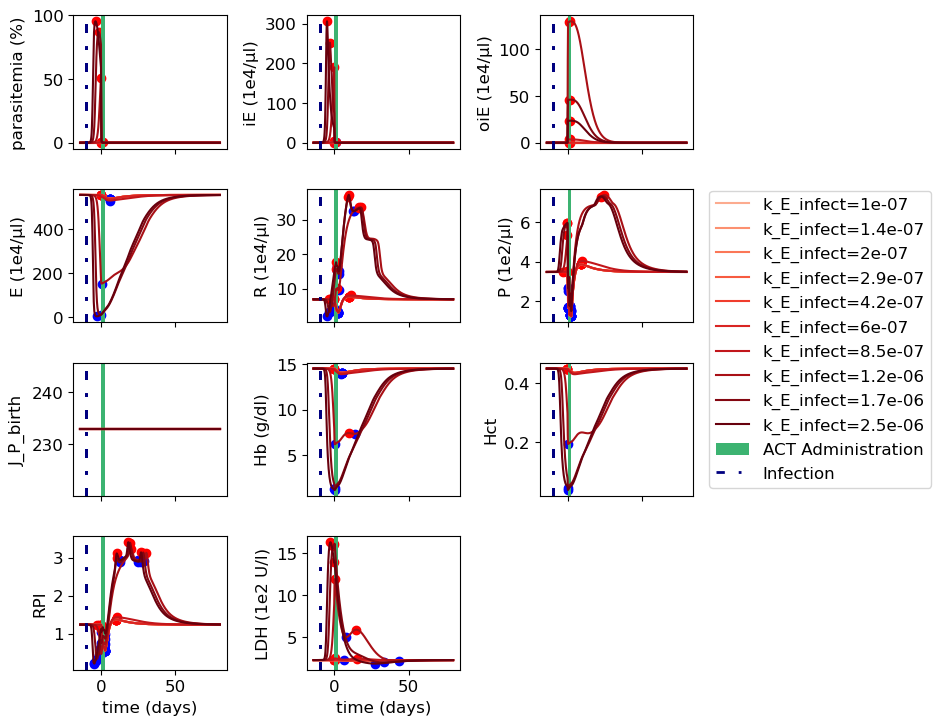

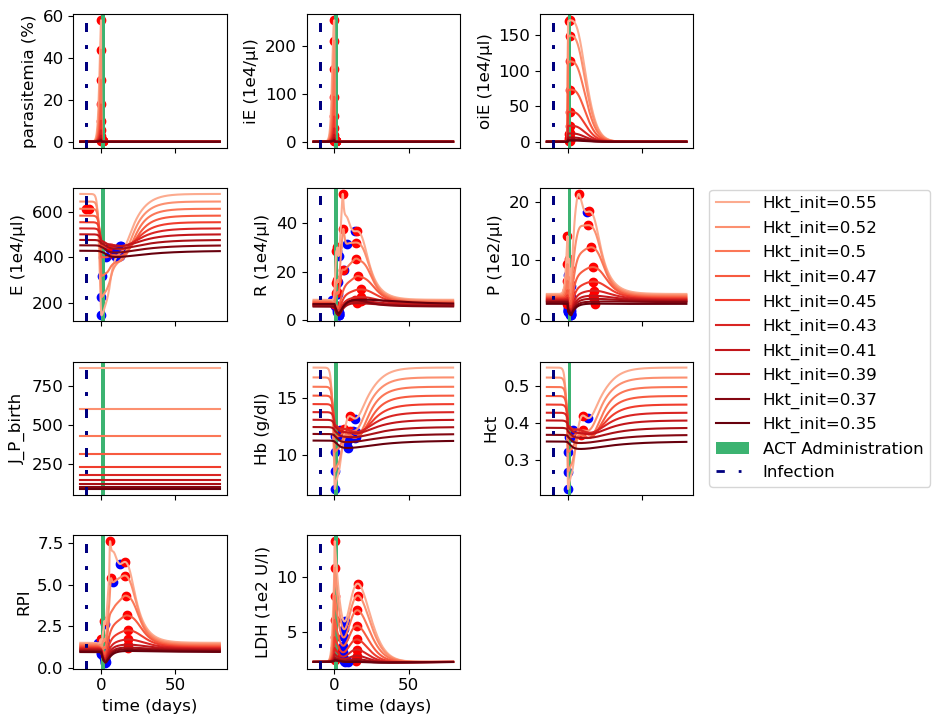

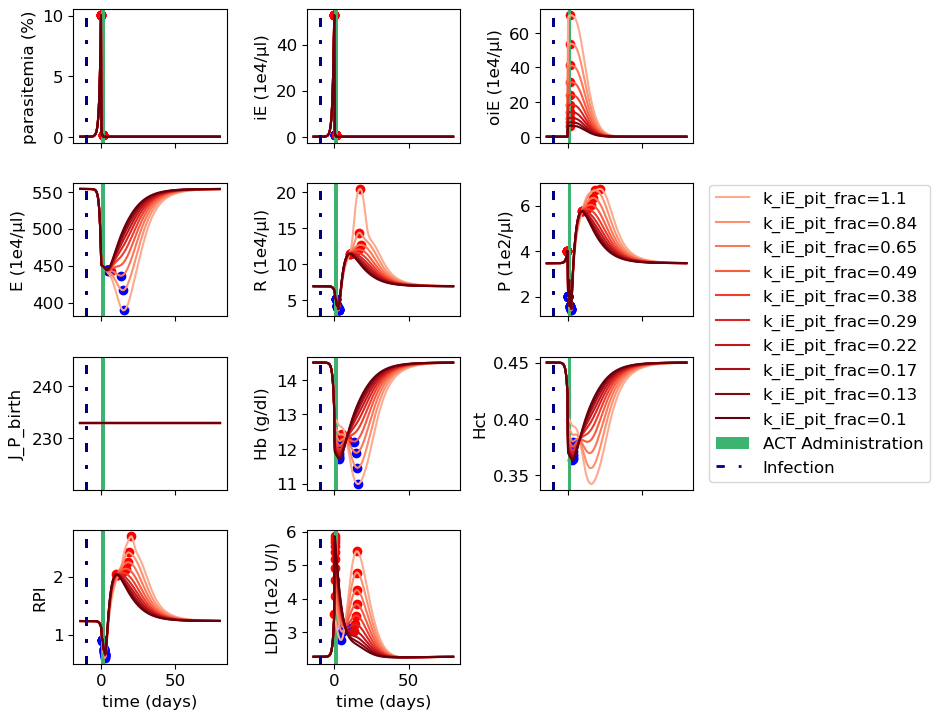

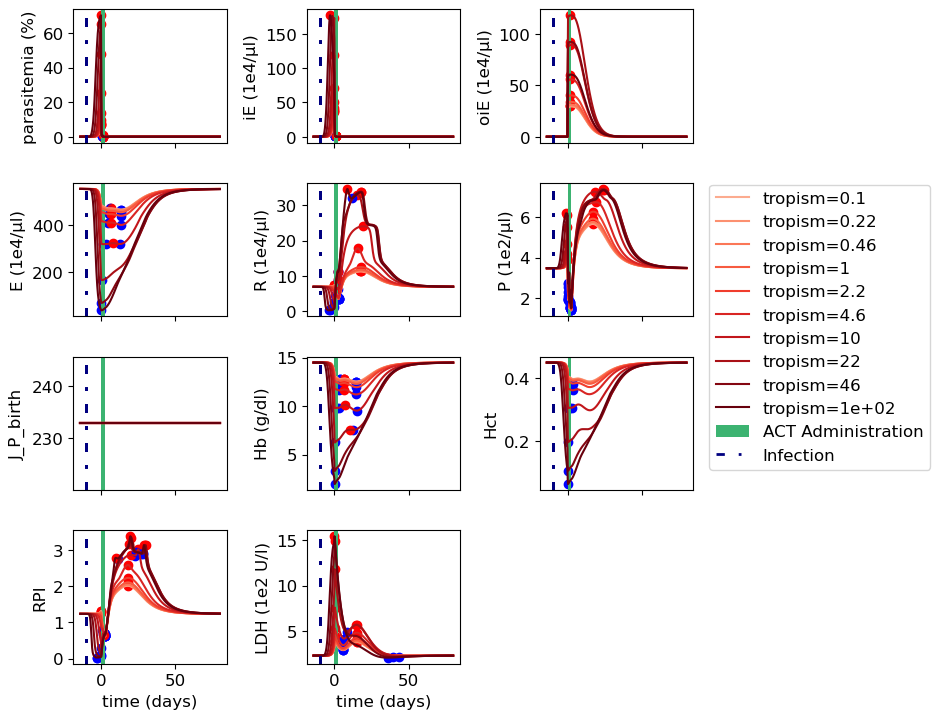

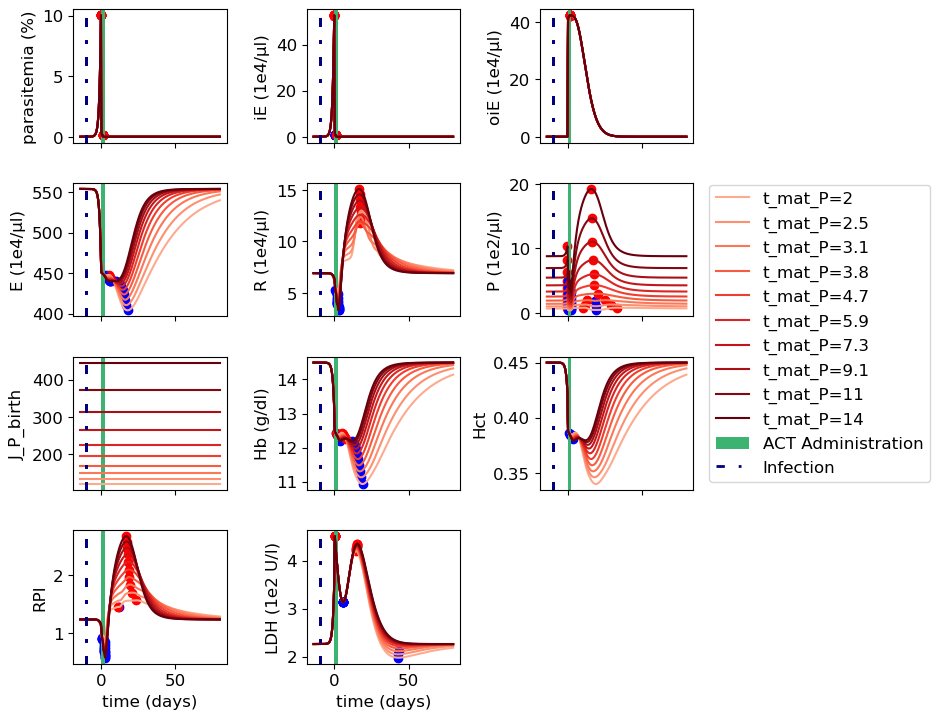

In [27]:
norm_result = simulate_model(infection_pars=update_pth, bool_med=True, bool_set_pars=True,
                            pre_t=pre_t, simulation_end=80, selections=['time']+list(species_to_analyze.keys()))	
# Farbübergang
cmap = plt.colormaps.get_cmap('Reds')
color_start = 0.3
for i, (param, values) in enumerate(param_values.items()):
    # Durchführung des Parameter-Scans und Erstellung der Plots
    cols = 3
    rows = int(np.ceil(len(species_to_analyze)/cols))   

    fig, axs = plt.subplots(rows,cols, figsize=(8,8.5), sharex=True)
    fig.subplots_adjust(hspace=0.3, wspace= 0.52)
    size_of_font = 12
    infection_dict = update_pth.copy()
    if param=='Hkt_init' or param=='k_iE_pit_frac':values=values[::-1]

    for idx, value in enumerate(values):

        infection_dict.update({param: 10**value})
        result = simulate_model(infection_pars=infection_dict, bool_med=True, bool_set_pars=True,
                                pre_t=pre_t, simulation_end=80, selections=['time']+list(species_to_analyze.keys()))	
        
        infection_dict.pop(param)
        #result_n = result/norm_result
        #result['time'] = norm_result['time']
        # Plotting
        for j, specie in enumerate (species_to_analyze.keys()):

            row = j //3
            col = j % 3
            
            #if specie in ['parasitemia','[iE]','oiE']:
            #    norm = result[specie]/result[specie].max()
            #else: norm = result[specie]/result[specie].iloc[0]
            #norm = norm.reset_index(drop=True)

            axs[row, col].plot(result['time'], result[specie]/species_to_analyze[specie][1], #
                               label=f'{param}={round(10**value,8):.2g}', 
                               color=cmap(color_start + idx * (00.8 / num_values_per_param)))
            #axs[row, col].set_xlabel('time (days)',fontsize= size_of_font)
            axs[row, col].set_ylabel(species_to_analyze[specie][0],fontsize= size_of_font)
            axs[row, col].tick_params(labelsize=size_of_font)

            plot_extrem_points(axs[row, col], result[specie]/species_to_analyze[specie][1],result['time'], n=50, eps=0.01)
            
            axs[row, col].axvspan(0, 2.3, facecolor='mediumseagreen', alpha=1, label='ACT Administration')
            #axs[row, col].axvspan(1, 1.3, facecolor='mediumseagreen', alpha=1, )
            #axs[row, col].axvspan(2, 2.3, facecolor='mediumseagreen', alpha=1, )

            axs[row, col].axvline(-pre_t, color='navy', alpha=1, linewidth=2, linestyle=(0, (3, 5, 1, 5)), label='Infection')   
            axs[row, col].tick_params(bottom='on')   
            if row == 4 - 1:
                axs[row, col].set_xlabel('time (days)',fontsize= size_of_font)
            
        handles, labels = axs[-2, -2].get_legend_handles_labels()  # Legend Box outsides Subplots


    axs[-3, -1].legend(handles[::3]+handles[-2::], labels[::3]+labels[-2::], loc='upper left', 
                       bbox_to_anchor=(1.05, 1.05),fontsize= size_of_font) #bbox (nach rechts-links, oben-unten, negativ yes)

    
    axs.flat[-1].set_visible(False)
    plt.savefig(f"figures/paramscan_{param}_min_max.pdf", format="pdf",bbox_inches='tight', dpi=200)
    #plt.tight_layout()
    plt.show()
    

### Parameterscan of all model parameters

In [28]:
paras_info_dict= {'Vol_blood':       ['1 µl', ' chosen fact',],
                  'Vol_plasma':      ['(1-Hct)* Vol_blood','medicine fact',],
                  'Vol_E':           ['80 fl','medicine fact',],
                  'Vol_R':           ['100 fl','medicine fact',],
                  'Vol_iE':          ['80 fl','medicine fact',],
                  'Vol_oiE':         ['50 fl','medicine fact',],
                  'Hb_conc_R':       ['300 g/l','paper value',],
                  'Hb_conc_E':       ['322.5 g/l','paper value',],
                  'Hb_conc_iE':      ['209.625 g/l', 'guessed ~ 65%',],
                  'Hb_conc_oiE':     ['316.05 g/l', 'guessed, similar to ring stage infected',],
                  't_E_death':       ['120','guess, medicine fact',],
                  't_iE_rupture':    ['2 days','medicine fact as rupure time for iE ',],
                  't_halb_LDH_decay':['4 days','guessed, medicine values 3-5 days',],
                  't_halb_ART_decay':['1/12 days','guessed, paper value 1-2 h',],
                  'h_art':           'guessed',
                  'ID50':            'guessed but depends on person weight and such',
                  'N_A':             'constant avogardo number',
                  't_R_a_init':      'SS calc',
                  't_P_a_init':      'SS calc',
                  'k_P_birth':       'SS calc',
                  'LDH_RBC':         'SS calc',
                  'k_oiE_death':     'fit, linear chain trick',
                  'scale_rpi':       'fit, medicine table',
                  'step_1':          'fit, medicine table',
                  'step_2':          'fit, medicine table',
                  'step_3':          'fit, medicine table',
                  'slope_rpi':       'guess',
                  'Hkt_init':        'guess',
                  't_mat_P':         'guess',
                  'a_P_d':           'guess',
                  'k_P_d':           'guess',
                  'r_P_d':           'guess',
                  's_BH':            'guess',
                  'tropism':         'guess, paper values between 2-10',
                  'k_E_infect':      'guess',
                  'k_iE_death_0':    'guess',
                  'k_iE_pit_frac':   'guess',
                  'k_iE_art_max':    'guess',
                  'k_P_art_max':     'guess',
                  'k_M_death':       'guess, paper value 48 /day',
                  'k_iE_pit_0':      'guess',
                  't_ART_add':       'set: time of ART administration',
                  
            }

In [29]:
model = te.loada('/home/nexia/PhD/pth_model/LCT_model/general_LCT_OIE.ant')

In [30]:
params_lst = ['t_mat_P',        # medicine fact
              't_R_a_init',     # calculated
              'scale_rpi',      # own idea
              'slope_rpi',      # own idea
              'Hkt_init',       # guess
              #'step_1',        # medicine fact
              #'step_2',        # medicine fact
              #'step_3',        # medicine fact
              #'t_P_a_init',    # SS calc
              'k_P_birth',      # SS calc
              #'LDH_RBC',       # calculated in Model
              #'Vol_blood',     # medicine fact
              't_E_death',      # medicine fact
              #'Vol_E',         # medicine fact
              #'Vol_R',         # medicine fact
              'k_oiE_death',    # fit from linear chain trick
              'a_P_d',          # paper value
              'k_P_d',          # paper value
              #'r_P_d',          # paper value
              's_BH',           # guess
              'tropism',        # paper values between 2-10
              'k_E_infect',     # guess
              'k_iE_death_0',   # guess
              'k_iE_pit_frac',  # guess
              'k_iE_art_max',   # guess
              'k_P_art_max',    # guess
              'h_art',          # guess
              'ID50',           # guess but depends on person weight and such
              't_iE_rupture',   # medicine fact =2 days as rupure time for iE 
              'k_M_death',      # paper value 48 /day
              't_halb_ART_decay', # paper value 1-2 h
              'k_iE_pit_0',     # guess
              't_halb_LDH_decay',# medicine values 3-5 days
              #'N_A',           # constant avogardo number
              #'Vol_iE',        # medicine fact 80fl
              #'Vol_oiE',       # medicine guess 50fl
              #'Hb_conc_R',      # paper value
              #'Hb_conc_E',      # paper value
              #'Hb_conc_iE',     # guess ~ 65%
              #'Hb_conc_oiE',    # guess similar to ring stage infected
              #'t_R_a_max',     # not used, for maturation time of P & R
              #'s_R_a',         # not used, for maturation time
              #'Hkt_0',         # not used, for maturation time
              #'t_ART_add',      # set, time of ART administration
              #'k_R_death',     # calculated in model 
              #'t_P_aging',     # calculated in model
              #'rpi_step_func', # calculated in model
              #'k_iE_death',    # calculated in model
              #'k_iE_pit',      # calculated in model
              #'Vol_plasma',    # medicine fact
            ]
param_values = {}
# Set model to estimated parameter values
for p in infection_dict:
   model.setValue(p, infection_dict[p])
# Build parameter scan dict
for para in params_lst:
  val_model = model.getValue(para)
  if val_model==0:
     val_model=1e-3
  # Erzeugung der Wertemengen für jeden Parameter
  param_values[para] = np.logspace(-0.1,1,num_values_per_param) * val_model
  
blub
# Farbübergang
cmap = plt.colormaps.get_cmap('Reds')
color_start = 0.3

for i, (param, values) in enumerate(param_values.items()):
    # Durchführung des Parameter-Scans und Erstellung der Plots
    cols = 3
    rows = int(np.ceil(len(species_to_analyze)/cols))   

    fig, axs = plt.subplots(rows,cols, figsize=(10,10.5), sharex=True)
    fig.subplots_adjust(hspace=0.3, wspace= 0.35)
    size_of_font = 12
    infection_dict = update_pth.copy()

    for idx, value in enumerate(values):

        infection_dict.update({param: value})
        try:
          result = simulate_model(infection_pars=infection_dict, bool_med=True, bool_set_pars=True,
                                  pre_t=pre_t, simulation_end=100, selections=['time']+list(species_to_analyze.keys()))	
        except:
           continue
        infection_dict.pop(param)
        
        # Plotting
        for j, specie in enumerate (species_to_analyze.keys()):

            row = j //3
            col = j % 3

            #norm = result[specie]/result[specie].iloc[0]
            #print(norm)
            axs[row, col].plot(result['time'], result[specie]/species_to_analyze[specie][1], 
                              label=f'{param}={round(value,8):.2e}', 
                              color=cmap(color_start + idx * (00.8 / num_values_per_param)))
            axs[row, col].set_xlabel('time (days)',fontsize= size_of_font)
            axs[row, col].set_ylabel(species_to_analyze[specie][0],fontsize= size_of_font)
            axs[row, col].tick_params(labelsize=size_of_font)

            axs[row, col].axvspan(0, 0.3, facecolor='mediumseagreen', alpha=1) #, label='ACT Administration')
            axs[row, col].axvspan(1, 1.3, facecolor='mediumseagreen', alpha=1)
            axs[row, col].axvspan(2, 2.3, facecolor='mediumseagreen', alpha=1)

            axs[row, col].axvline(-pre_t, color='navy', alpha=1, linewidth=2, linestyle=(0, (3, 5, 1, 5)))   
            
            
        handles, labels = axs[row, col].get_legend_handles_labels()  # Legend Box outsides Subplots

    axs[-1, -1].legend(handles, labels, loc='lower left', 
                      bbox_to_anchor=(1.05, 1.6),fontsize= size_of_font) #bbox (nach rechts-links, oben-unten, negativ yes)

#plt.savefig("./figures/paramscan_BHmax_short.pdf", format="pdf",bbox_inches='tight')
    plt.show()

#print(handles, labels)

#plt.savefig("plot.pdf")

NameError: name 'blub' is not defined

## Time Series Sensitivities

In [ ]:
import roadrunner
blub

NameError: name 'blub' is not defined

In [ ]:
from matplotlib import ticker
def plotTimeSeriesSens(time:np.array, sens:np.array,
                       rownames:list[str], colnames:list[str],
                       ax,ncol:int=3, ):
    """Plot time series sensitivities

    The time, sens, rownames and colnames arguments are generated
    with a call to roadrunner.timeSeriesSensitivities.

    :param time (np.array): The time points at which the time series sensitivity analysis was conducted.
    :param sens (3D np.array): The sensitivity matrix.
    :param rownames (List[str]): Names of parameters
    :param colnames (List[str]: Names of species
    :param ncol (int): Number of columns to plot. The number of rows is computed based on this number (default=3)
    :param fname (str): Default=None, if specified, full path to where to save the output figure.

    Example
    ---------
    import roadrunner as rr
    from roadrunner.tests.TestModelFactory import TestModelFactory, getAvailableTestModels
    sbml = TestModelFactory("Venkatraman2010").str()  # get the test model's sbml string
    time, sens, rownames, colnames = model.timeSeriesSensitivities(
        0, 10, 101, params=["keff1", "keff2", "keff3"], species=["tcUPA", "scUPA"])
    plotTimeSeriesSens(time, sens, rownames, colnames)
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    import seaborn as sns

    sns.set_style("white")
    sns.set_context("paper")

    total = len(rownames) * len(colnames)
    if ncol > total:
        ncol = total
    nrow = int(total / ncol if total % ncol == 0 else np.ceil(total / ncol))
    df_dct = {}
    for t, mat in zip(time, sens):
        df_dct[t] = pd.DataFrame(mat, columns=colnames, index=rownames)

    df = pd.concat(df_dct)
    df.index.names = ["time", "param"]
    df.columns.names = ["species"]
    df = df.unstack()

    for species in colnames:
        j=0
        i=0
        for param in rownames:
            #print("i", i, "species", species, "j", j, "param", param)
            #print("ax: ", type(ax), ax, ax.shape)
            #ax[i, j].plot(time, df[(species, param)].to_numpy(), label=f"{species}:{param}")
            ax[i, j].plot(time, df[(species, param)], label=f"{species}")
            handles, labels = ax[i, j].get_legend_handles_labels() 
            sns.despine(ax=ax[i, j], top=True, right=True, offset=-2.5)
            ax[i, j].set_title(f"{param}")
            ax[i,j].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2g}"))
            if j == 0:
                ax[i, j].set_ylabel(f"Sensitivities")
            if i == nrow-1:
                ax[i, j].set_xlabel(f"Time")
                j+=1
                i=0
                continue
            i+=1

    # Legend Box outsides Subplots            
    ax[-1, -1].legend(handles, labels, loc='lower left', bbox_to_anchor=(1.05, 1.6))
    return ax,df

In [ ]:
infection_dict= {
        "k_E_infect": 1.0351927708026337e-06,
        "tropism": 2.4824267001740767,
        "M": 100.0000740303447,
        "a_P_d": 9937191.134916836,
        "k_P_d": 0.009451056983160715,
        "r_P_d": 7.4265726002365495,
        "fac_R_d": 7.068386037799187e-10,
        "k_P_art_max": 2.709891804855283,
        "t_mat_P": 6.138028732895664,
        "k_iE_pit_frac": 0.6625125905514542,
        "t_E_death": 80.00000022727542,
        "s_BH": 7.105938524287848e-07, #change
        "LDH": 226.23256587878646,
        "k_M_death": 30.010891278063838
}
params_lst = [#'tropism',        # paper values between 2-10
              't_mat_P',        # medicine fact
              's_BH',           # guess
                 
              't_halb_ART_decay', # paper value 1-2 h
              'k_iE_pit_0',     # guess
              't_halb_LDH_decay',# medicine values 3-5 days
              'k_M_death',      # paper value 48 /day
              #'t_R_a_init',     # calculated
              'scale_rpi',      # own idea
              'slope_rpi',      # own idea
              #'Hkt_init',       # guess
              'k_P_birth',      # SS calc
              't_E_death',      # medicine fact
              'a_P_d',          # paper value
              'k_P_d',          # paper value
              'ID50',           # guess but depends on person weight and such
    
              'k_E_infect',     # guess
              'k_iE_death_0',   # guess
              'k_iE_pit_frac',  # guess
              'k_iE_art_max',   # guess
              'k_P_art_max',    # guess
              'h_art',          # guess
              
              #'t_iE_rupture',   # medicine fact =2 days as rupure time for iE 
           
            ]


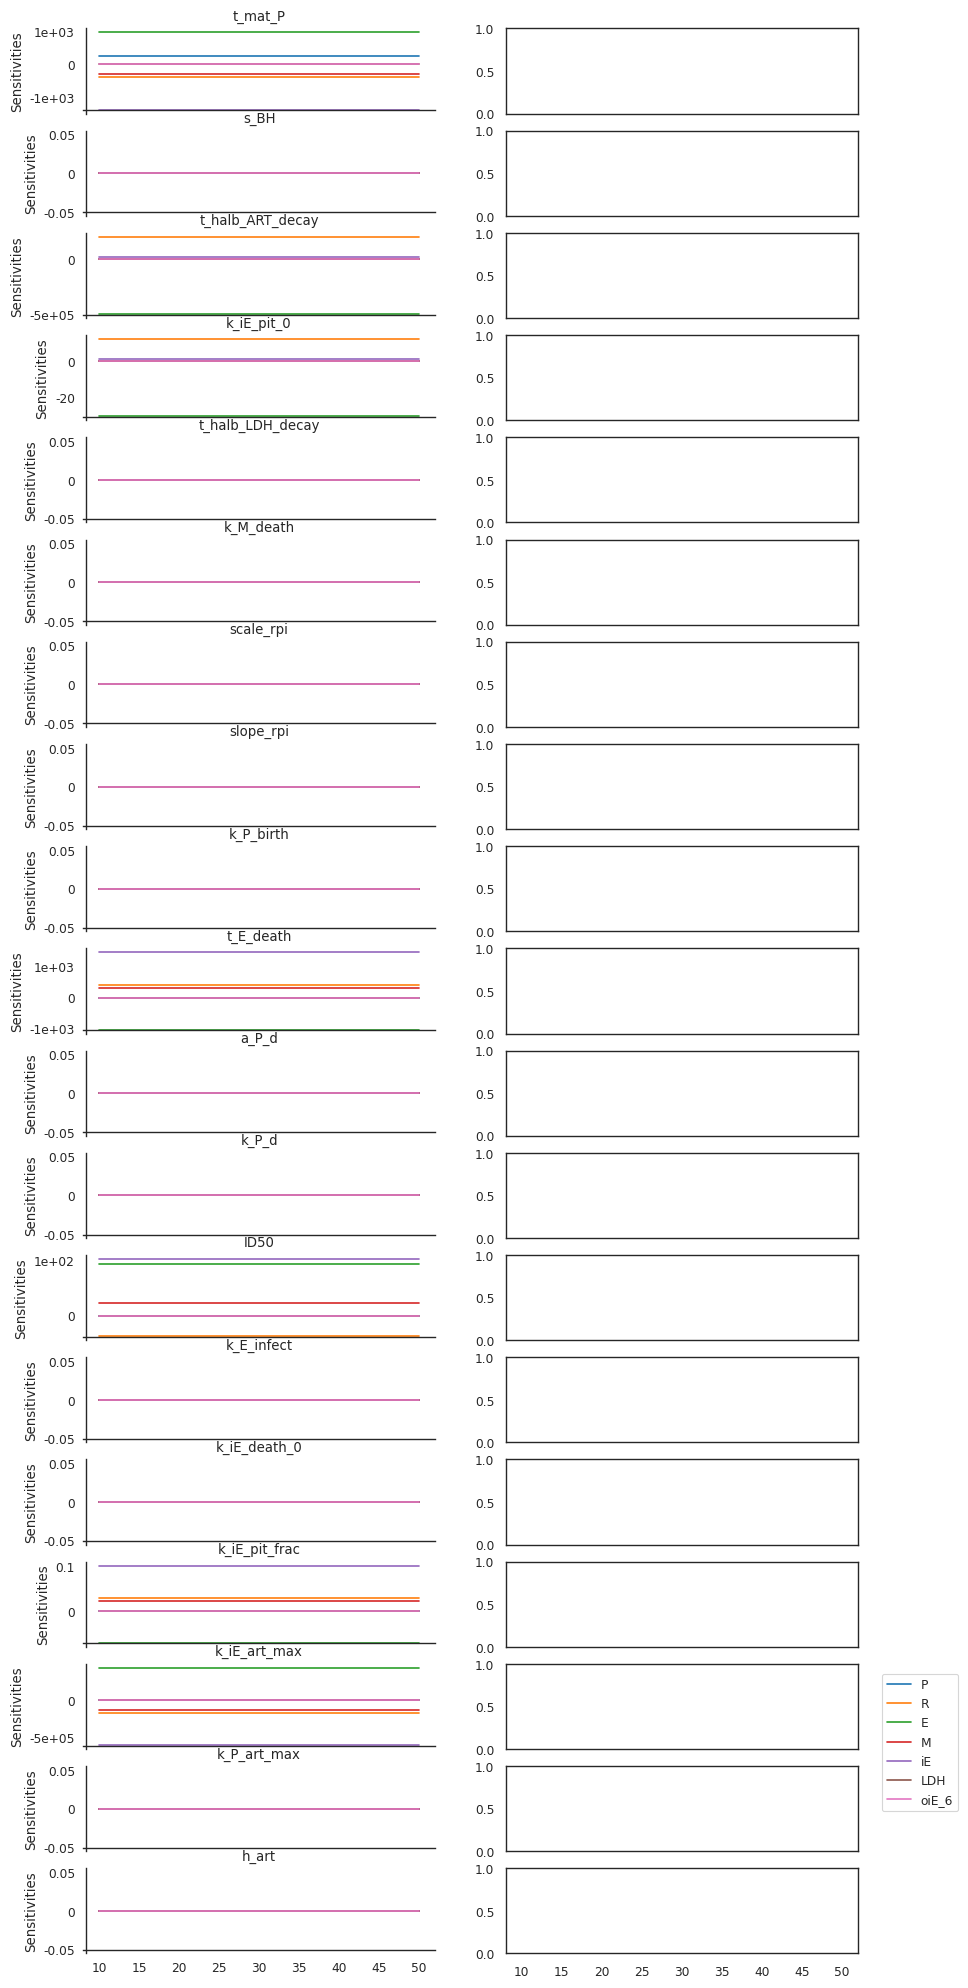

In [ ]:
cols=2
fig, ax = plt.subplots(nrows= int(total), ncols=cols, figsize=(10,25),sharex=True)
time, sens, rownames, colnames = model.timeSeriesSensitivities(10, 50, 61,species=species_lst, params=params_lst[:])
ax ,df = plotTimeSeriesSens(time, sens, rownames, colnames,ax,ncol=cols)
#fig.tight_layout()
plt.show()

In [ ]:
print(len(rownames))
print(len(colnames))

19
7


In [ ]:
sens.shape

(61, 19, 7)

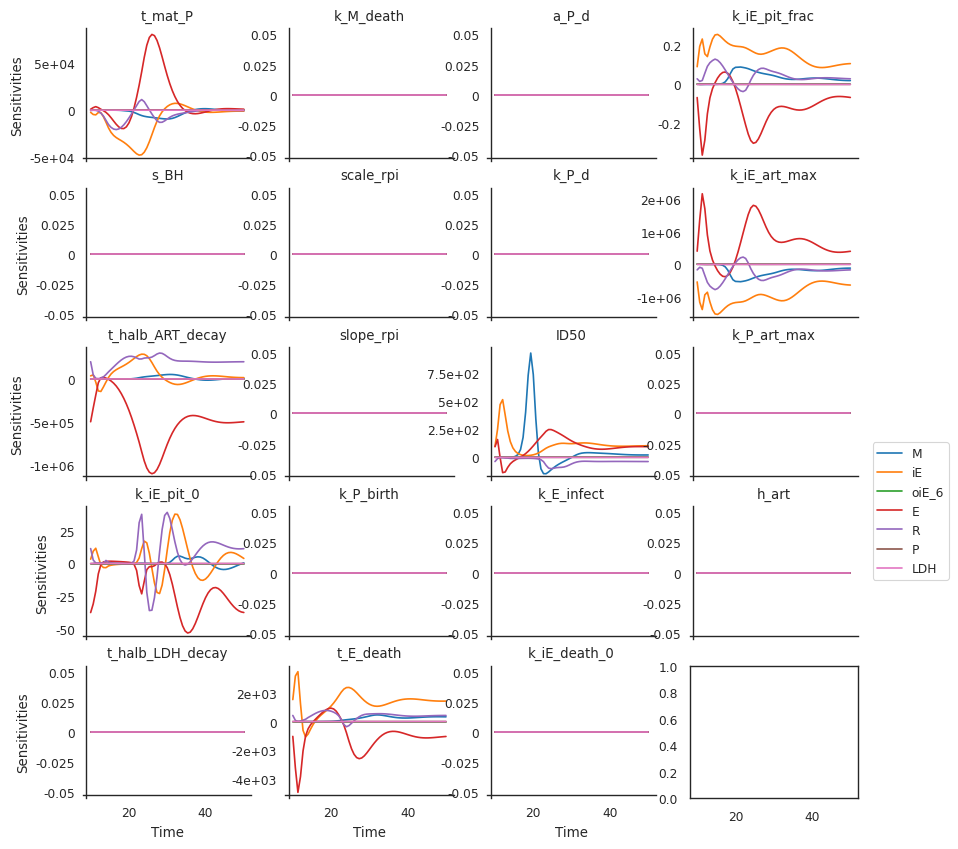

In [ ]:
model = te.loada('/home/nexia/PhD/pth_model/LCT_model/general_LCT_OIE.ant')
# Set model to estimated parameter values

for p in infection_dict:
   model.setValue(p, infection_dict[p])

sensSolver = model.getSensitivitySolver()
species_lst = ['M','iE','oiE_6','E','R','P','LDH']
cols = 4
total = len(params_lst)
fig, ax = plt.subplots(nrows= int(total / cols if total % cols == 0 else np.ceil(total / cols)), ncols=cols, figsize=(10,10),sharex=True)
# cannot be trusted
for species in species_lst:
   tmp_model = set_model_to_ss(model, infection_dict, model_name='general')
   time, sens, rownames, colnames = tmp_model.timeSeriesSensitivities(10, 50, 61,species=[species], params=params_lst[:])
   ax ,df = plotTimeSeriesSens(time, sens, rownames, colnames, ax, ncol=cols)
   del tmp_model, time, sens, rownames, colnames
#fig.tight_layout()
plt.show()

k_P_birth


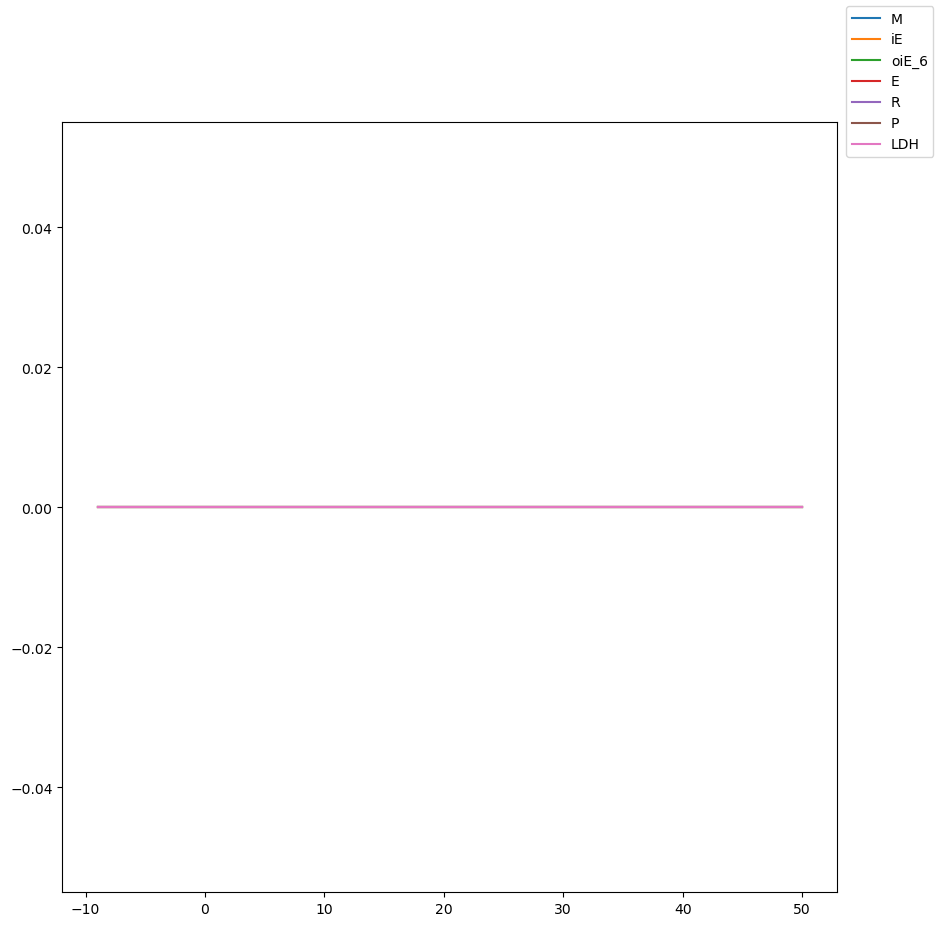

t_E_death


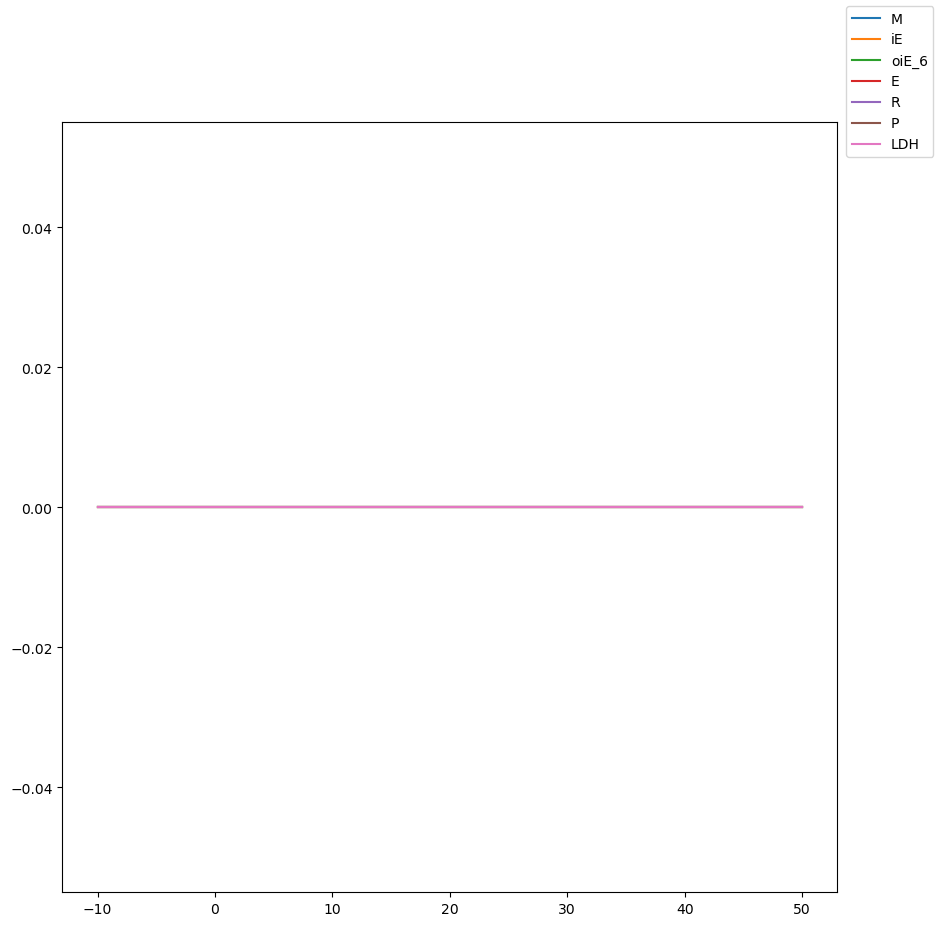

a_P_d


Error: ForwardSensitivitySolver Error: CV_TOO_MUCH_WORK, Module: CVODES, Function: CVode, Message: At t = -10, mxstep steps taken before reaching tout.


a_P_d didnt work
k_P_d


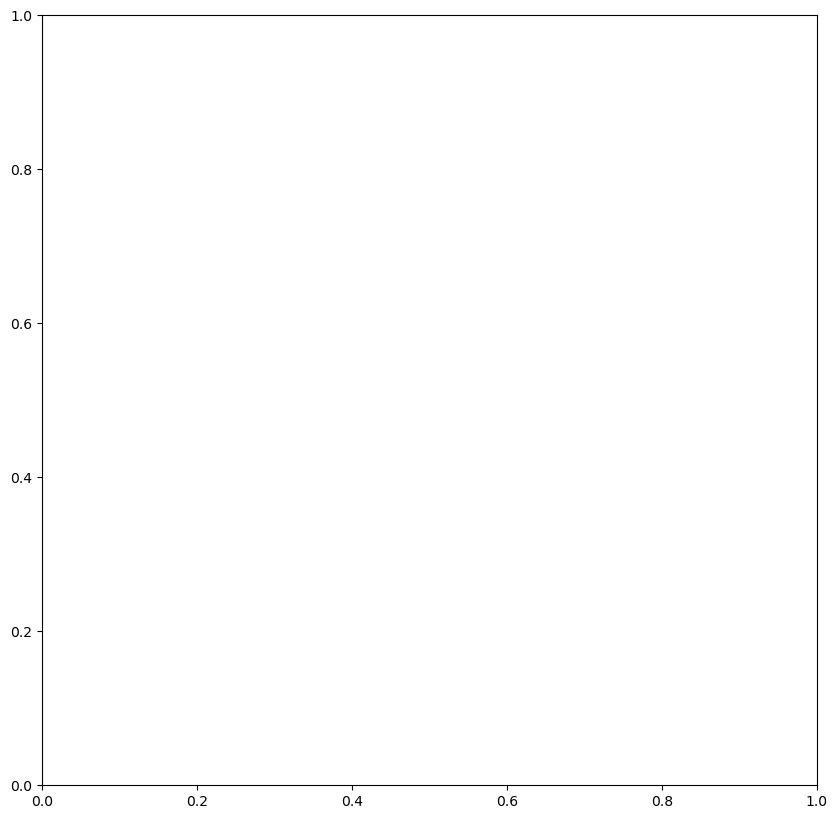

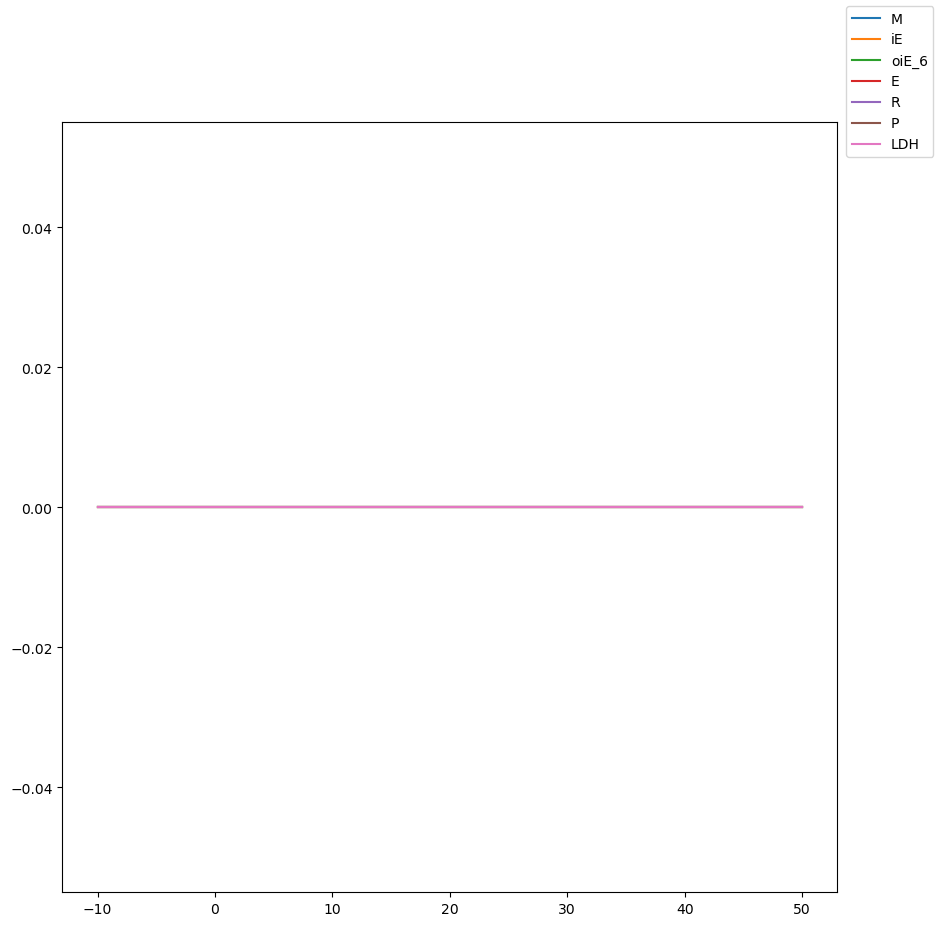

ID50


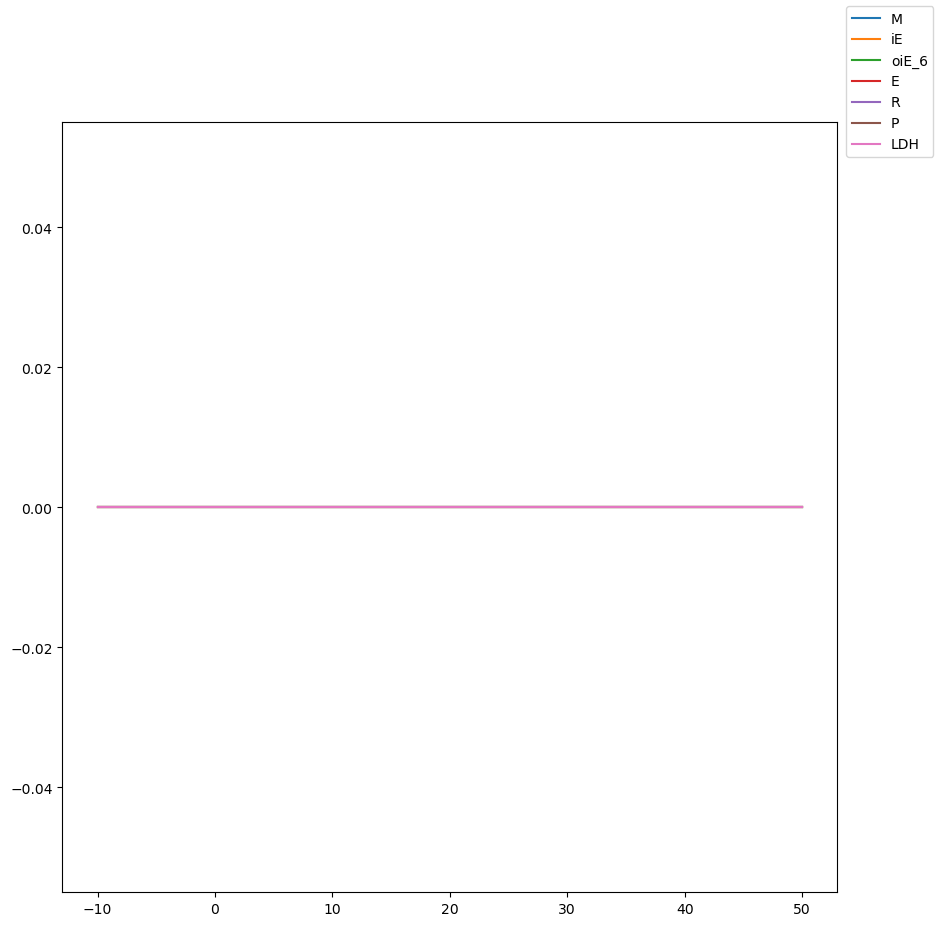

k_E_infect


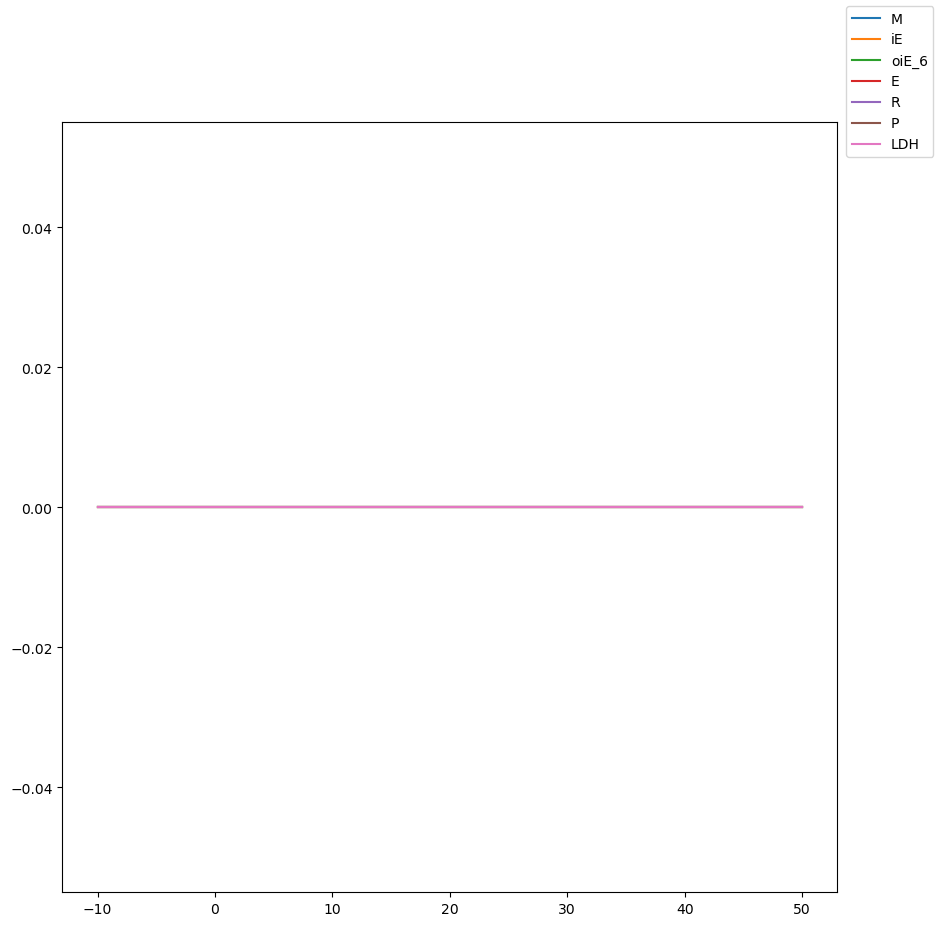

k_iE_death_0


Error: ForwardSensitivitySolver Error: CV_TOO_MUCH_WORK, Module: CVODES, Function: CVode, Message: At t = 1.08951, mxstep steps taken before reaching tout.


k_iE_death_0 didnt work
k_iE_pit_frac


Error: ForwardSensitivitySolver Error: CV_TOO_MUCH_WORK, Module: CVODES, Function: CVode, Message: At t = -9.89972, mxstep steps taken before reaching tout.


k_iE_pit_frac didnt work
k_iE_art_max


Error: ForwardSensitivitySolver Error: CV_TOO_MUCH_WORK, Module: CVODES, Function: CVode, Message: At t = -9.92471, mxstep steps taken before reaching tout.


k_iE_art_max didnt work
k_P_art_max


Error: ForwardSensitivitySolver Error: CV_TOO_MUCH_WORK, Module: CVODES, Function: CVode, Message: At t = -9.99374, mxstep steps taken before reaching tout.


k_P_art_max didnt work
h_art
h_art didnt work


Error: ForwardSensitivitySolver Error: CV_TOO_MUCH_WORK, Module: CVODES, Function: CVode, Message: At t = -9.98941, mxstep steps taken before reaching tout.


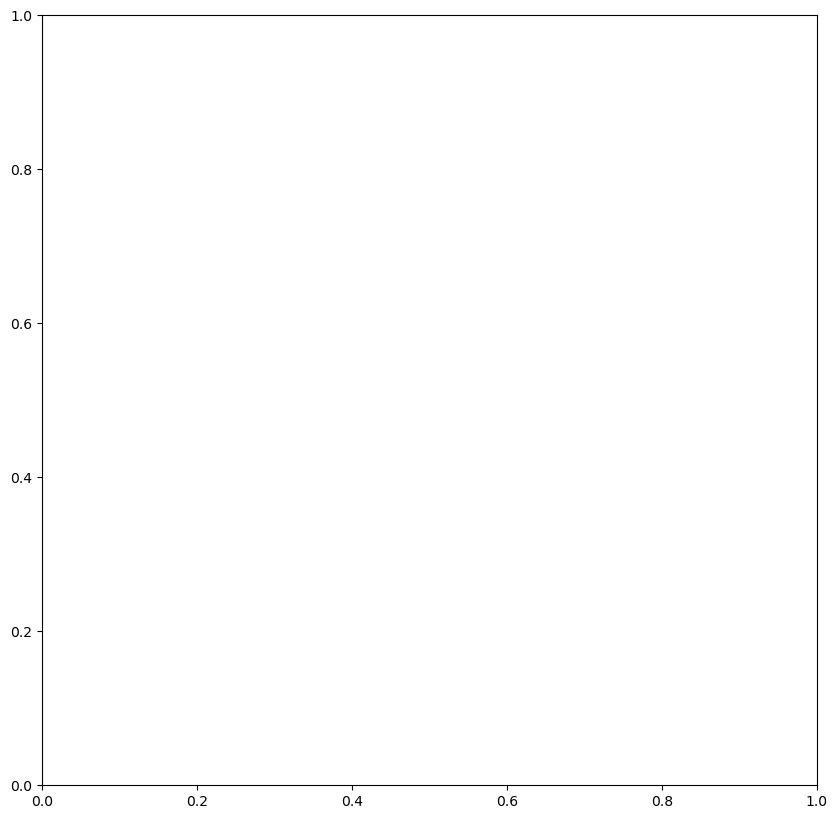

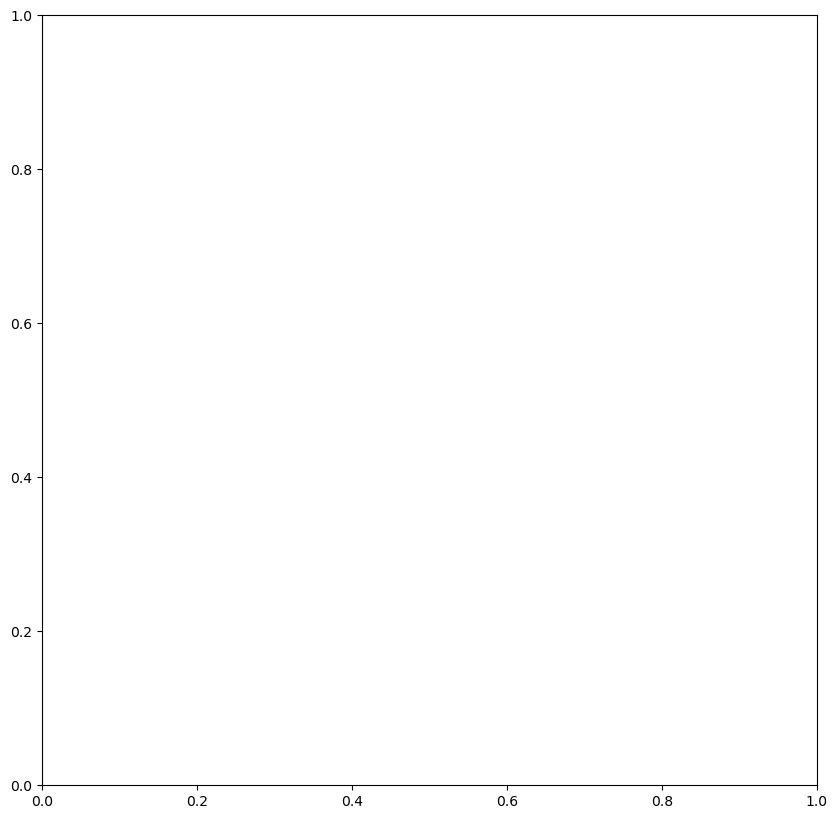

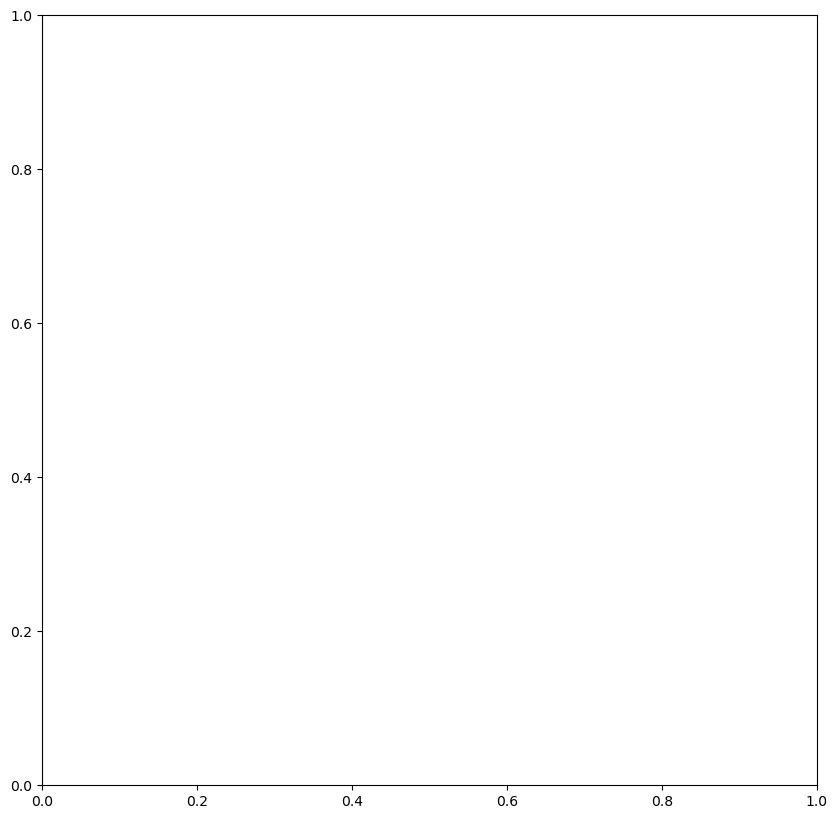

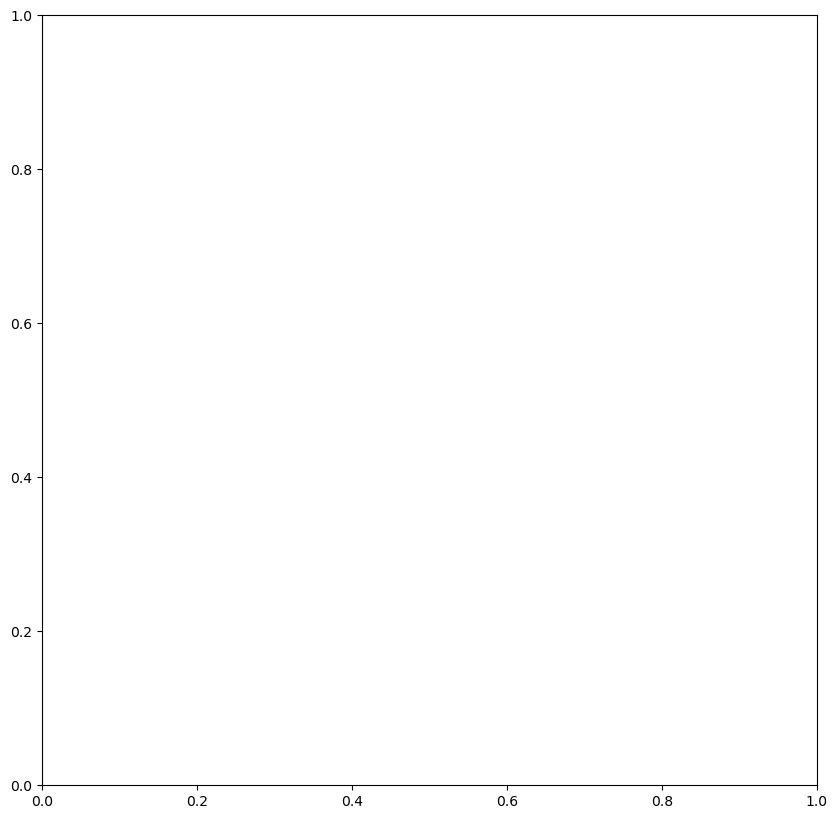

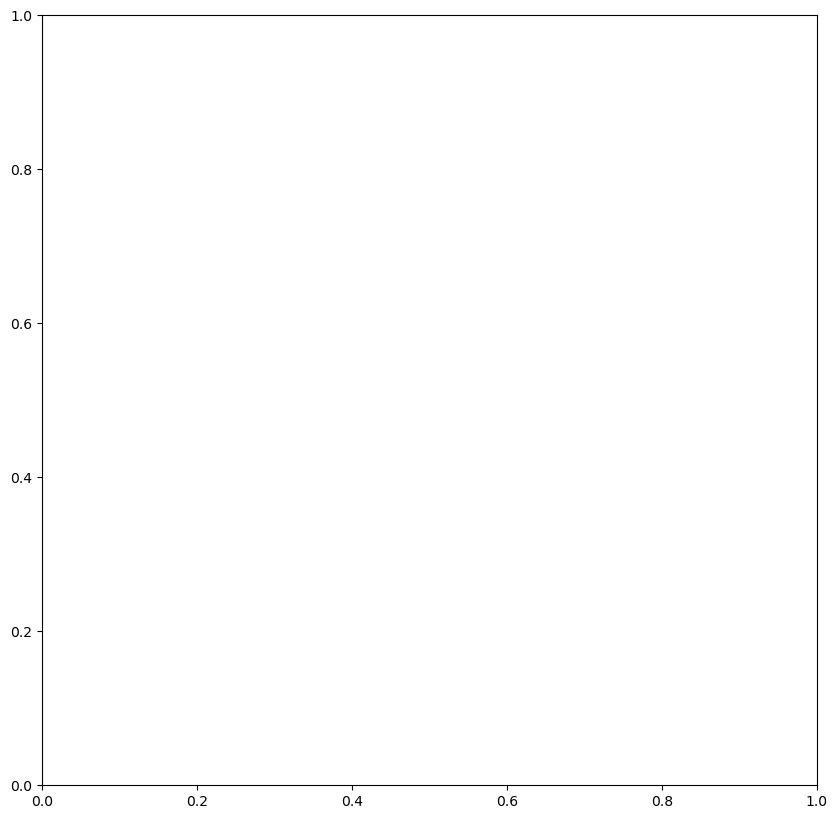

In [ ]:
model = te.loada('/home/nexia/PhD/pth_model/LCT_model/general_LCT_OIE.ant')
# Set model to estimated parameter values
for p in infection_dict:
   model.setValue(p, infection_dict[p])

sensSolver = model.getSensitivitySolver()
sensSolver.setValue("sensitivity_method", "staggered")

species_lst = ['M','iE','oiE_6','E','R','P','LDH']
for para in params_lst[8:]:
   print(para)
   #tmp_model.resetToOrigin()
   total = len(params_lst)
   #fig, ax = plt.subplots(nrows= int(total / 4 if total % 4 == 0 else np.ceil(total / 4)), ncols=4, figsize=(10,10),sharex=True)
   fig, ax = plt.subplots(figsize=(10,10),sharex=True)

   tmp_model = set_model_to_ss(model, infection_dict, model_name='general')
   #time, sens, rownames, colnames = tmp_model.timeSeriesSensitivities(-10, 50, 61,species=species_lst, params=[para])
   try:
      time, sens, rownames, colnames = tmp_model.timeSeriesSensitivities(-10, 50, 61,species=species_lst, params=[para])
      #print(sens)
   except RuntimeError:
      print(para+" didnt work")
      del tmp_model, fig, ax
      continue
   #fig.tight_layout()
   blub = np.array([0,0,0,0,0,0,0])
   for i, ar in enumerate(sens):
      blub = np.vstack((blub, ar[0]))
   sens_df = pd.DataFrame(blub[1:],columns=species_lst)
   #plotTimeSeriesSens(time, sens, rownames, colnames, ax, ncol=4)
   ax.plot(time,sens_df, label=species_lst)
   fig.legend()
   plt.show()
   del time, sens, rownames, colnames, tmp_model, fig, ax, sens_df